In [1]:
import numpy as np
import random
import os
import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()

import pandas as pd
df = pd.read_csv('datasets/local_cache/dataset_12500_samples_65_features.csv')

cols_to_drop = [
    'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt',
    'ack_flag_cnt', 'urg_flag_cnt', 'cwe_flag_cnt', 'ece_flag_cnt',
    'fwd_header_length', 'bwd_header_length',
    'active_mean', 'active_std', 'active_max', 'active_min',
    'idle_mean', 'idle_std', 'idle_max', 'idle_min',
    'subflow_fwd_bytes'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])



In [2]:
df.columns

Index(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flow_duration',
       'total_fwd_packets', 'total_bwd_packets', 'total_len_fwd_packets',
       'total_len_bwd_packets', 'fwd_pkt_len_max', 'fwd_pkt_len_min',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'fwd_seg_size_min',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'bwd_seg_size_min', 'pkt_len_mean', 'pkt_len_std',
       'pkt_len_var', 'flow_bytes_per_s', 'flow_packets_per_s',
       'fwd_packets_per_s', 'bwd_packets_per_s', 'bandwidth_bps',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'down_up_ratio', 'avg_packet_size',
       'avg_fwd_segment_size', 'avg_bwd_segment_size', 'flow_rate_entropy',
       'label'],
      dtype='object')

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
CFG = {
    'local_epochs': 1,
    'lr': 1e-3,
    'loss_weights': {'traffic':1,'duration':1,'bandwidth':1},
    'test_size': 0.2,
    'alpha': 0.4,
    'n_clients_flat': 600,
    'n_clusters': 3,     # Hierarchical: 3 clusters
    'clients_per_cluster': 200,  # 200 clients per cluster
    'client_frac': 1,  # 80% of clients participate per round
    'global_aggregator_cluster': 1,  # Cluster 1 performs global aggregation
    'split_type': 'dirichlet',  # 'equal' or 'dirichlet'
}

In [5]:
exclude_traffic = [
     'src_ip', 'dst_ip', 'src_port', 'dst_port',   # identity → leakage
    'protocol',                                   # not useful for QUIC-only
    'label', 'flow_duration', 'flow_bytes_per_s',
  'bandwidth_bps'                             # traffic classification target
]


Xcols_traffic = [col for col in df.columns if col not in exclude_traffic]

exclude_duration = [
     'src_ip', 'dst_ip', 'src_port', 'dst_port',   # identity → leakage
    'protocol',                                   # not useful for QUIC-only
    'label', 'flow_duration', 'flow_bytes_per_s',
  'bandwidth_bps'                                          # traffic classification target
]



Xcols_duration = [col for col in df.columns if col not in exclude_duration]

exclude_bandwidth = [
 'src_ip', 'dst_ip', 'src_port', 'dst_port',   # identity → leakage
    'protocol',                                   # not useful for QUIC-only
    'label', 'flow_duration', 'flow_bytes_per_s',
  'bandwidth_bps'                                        # traffic classification target
]


Xcols_bandwidth = [col for col in df.columns if col not in exclude_bandwidth]


In [6]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

n = len(df)
indices = np.arange(n)
train_idx, test_idx = train_test_split(indices, test_size = CFG['test_size'], random_state = seed, shuffle = True)

In [7]:
train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

In [8]:
all_features = list(set(Xcols_traffic + Xcols_duration + Xcols_bandwidth))

In [9]:
winsor_bounds = {}
for col in all_features:
    if col in train_df.columns:
        lower = train_df[col].quantile(0.01)
        upper = train_df[col].quantile(0.99)
        winsor_bounds[col] = (lower, upper)

In [10]:
for col, (lower, upper) in winsor_bounds.items():
    lower_limit = (train_df[col] < lower).mean()
    upper_limit = (train_df[col] > upper).mean()
    
    for df in [train_df, test_df]:
        df[col] = winsorize(df[col], limits=(lower_limit, upper_limit))
train_df.head()

,src_ip,dst_ip,src_port,dst_port,protocol,flow_duration,total_fwd_packets,total_bwd_packets,total_len_fwd_packets,total_len_bwd_packets,...,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,down_up_ratio,avg_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,flow_rate_entropy,label
4622,156.248.33.211,162.159.135.232,61710,443,17,159609.0,10,8,3472,2149,...,11.375000,28.965227,88,0,0.618088,312.111111,347.200000,268.250000,2.105411,discord
409,114.175.67.33,157.240.30.63,46291,443,17,22109380.0,74,130,26428,82282,...,6.937500,12.198713,43,0,3.113440,532.892157,357.135135,632.938462,2.081266,instagram
4338,156.248.48.58,162.159.133.233,49483,443,17,56490.0,33,57,4128,58164,...,0.250000,0.572276,2,0,14.090116,692.133333,125.090909,1020.421053,1.695259,discord
8119,149.52.129.88,142.251.36.138,51156,443,17,2092069.0,20,20,3514,3620,...,17.666667,22.377568,75,0,1.030165,182.421053,175.700000,181.000000,2.180094,google-services
3026,156.234.23.157,162.159.128.233,63093,443,17,255790.0,9,8,3236,2603,...,26.875000,70.727359,214,0,0.804388,343.470588,359.555556,325.375000,2.063559,discord


In [11]:
import numpy as np

# Raw values
y_dur_raw_train = train_df['flow_duration'].values
y_bw_raw_train  = train_df['bandwidth_bps'].values

# Log-transform
bw_log  = np.log1p(y_bw_raw_train)
dur_log = np.log1p(y_dur_raw_train)

# Compute 5-bin quantiles (20%, 40%, 60%, 80%)
bw_quantiles  = np.quantile(bw_log,  [0.20, 0.40, 0.60, 0.80])
dur_quantiles = np.quantile(dur_log, [0.20, 0.40, 0.60, 0.80])

# Create labels with digitize
def create_quantile_labels(raw_values, quantiles):
    """
    Same as your original function, but:
    - now 5 classes (0..4)
    - uses np.digitize
    - still log-transforms first
    """
    v = np.log1p(raw_values)
    labels = np.digitize(v, quantiles, right=False)   # returns 0..4
    return labels

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
y_dur_train = create_quantile_labels(train_df['flow_duration'].values, dur_quantiles)
y_dur_test = create_quantile_labels(test_df['flow_duration'].values, dur_quantiles)

y_bw_train = create_quantile_labels(train_df['bandwidth_bps'].values, bw_quantiles)
y_bw_test = create_quantile_labels(test_df['bandwidth_bps'].values, bw_quantiles)

le_traf = LabelEncoder()
y_traf_train = le_traf.fit_transform(train_df['label'])
y_traf_test = le_traf.transform(test_df['label'])

feature_scaler = StandardScaler()
train_df[all_features] = feature_scaler.fit_transform(train_df[all_features])
test_df[all_features] = feature_scaler.transform(test_df[all_features])

In [13]:
X_traffic_train = train_df[Xcols_traffic].values
X_duration_train = train_df[Xcols_duration].values
X_bandwidth_train = train_df[Xcols_bandwidth].values


X_traffic_test = test_df[Xcols_traffic].values
X_duration_test = test_df[Xcols_duration].values
X_bandwidth_test = test_df[Xcols_bandwidth].values

In [14]:
max_dim = max(X_traffic_train.shape[1], X_duration_train.shape[1], X_bandwidth_train.shape[1])

def pad_features(X, target_size):
    if X.shape[1] < target_size:
        padding = np.zeros((X.shape[0], target_size - X.shape[1]))
        return np.concatenate([X, padding], axis=1)
    return X

X_traffic_train = pad_features(X_traffic_train, max_dim)
X_duration_train = pad_features(X_duration_train, max_dim)
X_bandwidth_train = pad_features(X_bandwidth_train, max_dim)

X_traffic_test = pad_features(X_traffic_test, max_dim)
X_duration_test = pad_features(X_duration_test, max_dim)
X_bandwidth_test = pad_features(X_bandwidth_test, max_dim)

In [15]:
from sklearn.feature_selection import mutual_info_classif

def find_high_mi_features(X_cols, y_train, train_df, task_name, seed, threshold=0.2): 
    X_train = train_df[X_cols].values
    
    try:
        mi_scores = mutual_info_classif(
            X_train,
            y_train,
            discrete_features=False,
            random_state=seed
        )
    except Exception as e:
        print(f"Error calculating MI for {task_name}: {e}", file=sys.stderr)
        return []

    mi_results = dict(zip(X_cols, mi_scores))
    
    problematic = []
    for feat, mi in mi_results.items():
        if mi > threshold:
            problematic.append((feat, mi))
    
    if problematic:
        print(f"Found {len(problematic)} features with MI > {threshold}:")
        # Sort by MI score, descending
        problematic.sort(key=lambda x: x[1], reverse=True)
        for feat, mi in problematic:
            print(f"  • {feat}: {mi:.4f}")
    else:
        print(f"No features found with MI > {threshold}.")
        
    return problematic

problematic_dur = find_high_mi_features(
    Xcols_duration, y_dur_train, train_df, 'Duration', seed
)

problematic_bw = find_high_mi_features(
    Xcols_bandwidth, y_bw_train, train_df, 'Bandwidth', seed
)

problematic_tf = find_high_mi_features(
    Xcols_traffic, y_traf_train, train_df, 'Traffic Category', seed
)

all_diagnostics = {
    'duration': problematic_dur,
    'bandwidth': problematic_bw,
    'traffic': problematic_tf
}

Found 30 features with MI > 0.2:
  • bwd_packets_per_s: 0.9275
  • flow_packets_per_s: 0.9051
  • fwd_packets_per_s: 0.8397
  • flow_iat_mean: 0.7458
  • flow_iat_max: 0.7057
  • flow_iat_std: 0.6616
  • fwd_iat_total: 0.5753
  • fwd_iat_std: 0.5706
  • fwd_iat_max: 0.5513
  • fwd_iat_mean: 0.5258
  • total_len_bwd_packets: 0.4346
  • avg_bwd_segment_size: 0.3980
  • bwd_iat_mean: 0.3912
  • flow_rate_entropy: 0.3786
  • bwd_pkt_len_mean: 0.3691
  • bwd_iat_total: 0.3652
  • total_bwd_packets: 0.3566
  • bwd_pkt_len_std: 0.3464
  • total_len_fwd_packets: 0.3417
  • bwd_iat_std: 0.3185
  • total_fwd_packets: 0.2927
  • bwd_iat_max: 0.2622
  • down_up_ratio: 0.2493
  • fwd_pkt_len_std: 0.2453
  • avg_packet_size: 0.2373
  • pkt_len_mean: 0.2371
  • avg_fwd_segment_size: 0.2362
  • fwd_pkt_len_mean: 0.2347
  • pkt_len_std: 0.2248
  • pkt_len_var: 0.2244
Found 30 features with MI > 0.2:
  • bwd_packets_per_s: 1.2198
  • flow_packets_per_s: 1.1862
  • fwd_packets_per_s: 1.0154
  • flow_iat_

In [16]:
# Client partitioning with support for both Equal and Dirichlet splits
def build_client_partitions(split_type='dirichlet', verbose=True):
    """
    Build client partitions with specified data distribution
    
    Args:
        split_type: 'equal' or 'dirichlet'
        verbose: Print statistics
        
    Returns:
        client_indices_flat: List of client data indices
        client_index_to_cluster: Dict mapping client idx to cluster id
    """
    n_clients = CFG['n_clients_flat']
    n_clusters = CFG['n_clusters']
    clients_per_cluster = CFG['clients_per_cluster']
    alpha = CFG['alpha']
    min_size = 50
    rng = np.random.default_rng(seed)
    
    labels = np.unique(y_traf_train)
    label_indices = {}
    train_indices = np.arange(len(y_traf_train))
    
    for lbl in labels:
        label_indices[lbl] = train_indices[y_traf_train == lbl]
    
    if split_type == 'equal':
        # Equal split: divide samples equally among clusters
        samples_per_cluster = len(y_traf_train) // n_clusters
        cluster_indices = []
        
        for cluster_id in range(n_clusters):
            start_idx = cluster_id * samples_per_cluster
            end_idx = start_idx + samples_per_cluster if cluster_id < n_clusters - 1 else len(y_traf_train)
            cluster_indices.append(np.arange(start_idx, end_idx))
        
        # Divide each cluster's data among its clients
        client_indices_flat = []
        client_index_to_cluster = {}
        
        for cluster_id, cluster_idxs in enumerate(cluster_indices):
            np.random.shuffle(cluster_idxs)
            samples_per_client = len(cluster_idxs) // clients_per_cluster
            
            for local_client_id in range(clients_per_cluster):
                start = local_client_id * samples_per_client
                end = start + samples_per_client if local_client_id < clients_per_cluster - 1 else len(cluster_idxs)
                client_idxs = cluster_idxs[start:end]
                client_indices_flat.append(client_idxs)
                
                global_client_id = cluster_id * clients_per_cluster + local_client_id
                client_index_to_cluster[global_client_id] = cluster_id
        
    elif split_type == 'dirichlet':
        # Dirichlet split: non-IID distribution
        client_bins = [[] for _ in range(n_clients)]
        
        for lbl in labels:
            idxs = label_indices[lbl]
            rng.shuffle(idxs)
            proportions = rng.dirichlet([alpha] * n_clients)
            cuts = (np.cumsum(proportions) * len(idxs)).astype(int)
            parts = np.split(idxs, cuts[:-1])
            
            for i, part in enumerate(parts):
                client_bins[i].extend(part.tolist())
        
        # Ensure minimum size
        for i in range(n_clients):
            if len(client_bins[i]) < min_size:
                need = min_size - len(client_bins[i])
                extra = rng.choice(train_indices, size=need, replace=False)
                client_bins[i].extend(extra.tolist())
        
        client_indices_flat = []
        client_index_to_cluster = {}
        
        for i, bin_data in enumerate(client_bins):
            clean = np.array(sorted(set(bin_data)))
            client_indices_flat.append(clean)
            
            # Assign to clusters sequentially
            cluster_id = i // clients_per_cluster
            client_index_to_cluster[i] = cluster_id
    else:
        raise ValueError(f"Unknown split_type: {split_type}")
    
    if verbose:
        print(f"Created {len(client_indices_flat)} clients ({split_type} split)")
        print(f"Sample sizes: min={min([len(c) for c in client_indices_flat])}, "
              f"max={max([len(c) for c in client_indices_flat])}, "
              f"avg={np.mean([len(c) for c in client_indices_flat]):.1f}")
        
        # Check cluster distribution
        for cluster_id in range(n_clusters):
            cluster_clients = [i for i in range(n_clients) if client_index_to_cluster[i] == cluster_id]
            cluster_samples = sum(len(client_indices_flat[i]) for i in cluster_clients)
            print(f"Cluster {cluster_id}: {len(cluster_clients)} clients, {cluster_samples} total samples")
        
        # Check label distribution for first 5 clients
        for i in range(min(5, len(client_indices_flat))):
            indices = client_indices_flat[i]
            labels_count = {}
            for lbl in labels:
                count = np.sum(y_traf_train[indices] == lbl)
                if count > 0:
                    labels_count[lbl] = count
            print(f"Client {i} (Cluster {client_index_to_cluster[i]}): {labels_count}")
    
    return client_indices_flat, client_index_to_cluster

# Build clients with specified split type
client_indices_flat, client_index_to_cluster = build_client_partitions(
    split_type=CFG['split_type'], 
    verbose=True
)


Created 600 clients (dirichlet split)
Sample sizes: min=48, max=85, avg=50.1
Cluster 0: 200 clients, 9997 total samples
Cluster 1: 200 clients, 10049 total samples
Cluster 2: 200 clients, 10018 total samples
Client 0 (Cluster 0): {np.int64(0): np.int64(3), np.int64(1): np.int64(12), np.int64(2): np.int64(6), np.int64(3): np.int64(20), np.int64(4): np.int64(9)}
Client 1 (Cluster 0): {np.int64(0): np.int64(1), np.int64(1): np.int64(5), np.int64(2): np.int64(6), np.int64(3): np.int64(28), np.int64(4): np.int64(10)}
Client 2 (Cluster 0): {np.int64(0): np.int64(6), np.int64(1): np.int64(11), np.int64(2): np.int64(8), np.int64(3): np.int64(9), np.int64(4): np.int64(16)}
Client 3 (Cluster 0): {np.int64(0): np.int64(13), np.int64(1): np.int64(8), np.int64(2): np.int64(12), np.int64(3): np.int64(10), np.int64(4): np.int64(7)}
Client 4 (Cluster 0): {np.int64(0): np.int64(5), np.int64(1): np.int64(12), np.int64(2): np.int64(9), np.int64(3): np.int64(10), np.int64(4): np.int64(14)}


In [17]:
class ClientData:
    def __init__(self, data_dict, cluster_id):
        self.ds = data_dict
        self.cluster_id = cluster_id

clients = []
for i, indices in enumerate(client_indices_flat):
    
    X_traffic_client = X_traffic_train[indices]
    X_duration_client = X_duration_train[indices]
    X_bandwidth_client = X_bandwidth_train[indices]
    
    y_traffic_client = y_traf_train[indices]
    y_duration_client = y_dur_train[indices]
    y_bandwidth_client = y_bw_train[indices]
    
    client_data_dict = {
        'traffic': (X_traffic_client.astype(np.float32), y_traffic_client),
        'duration': (X_duration_client.astype(np.float32), y_duration_client),
        'bandwidth': (X_bandwidth_client.astype(np.float32), y_bandwidth_client)
    }
    
    cluster_id = client_index_to_cluster[i]
    clients.append(ClientData(client_data_dict, cluster_id))

print(f"  Traffic features shape: {clients[0].ds['traffic'][0].shape}")
print(f"  Traffic labels shape: {clients[0].ds['traffic'][1].shape}")
print(f"  Duration features shape: {clients[0].ds['duration'][0].shape}")
print(f"  Bandwidth features shape: {clients[0].ds['bandwidth'][0].shape}")
print(f"  Total clients: {len(clients)}, Clusters: {CFG['n_clusters']}")

  Traffic features shape: (50, 39)
  Traffic labels shape: (50,)
  Duration features shape: (50, 39)
  Bandwidth features shape: (50, 39)
  Total clients: 600, Clusters: 3


In [18]:
test_data = {
    'traffic': (X_traffic_test.astype(np.float32), y_traf_test.astype(int)),
    'duration': (X_duration_test.astype(np.float32), y_dur_test.astype(int)),
    'bandwidth': (X_bandwidth_test.astype(np.float32), y_bw_test.astype(int))
}

In [19]:
# ---- Unique class summaries -------------------------------------------------

print("Unique Classes:")
print(f"  Duration classes:  {sorted(np.unique(y_dur_train))}   (0=Short, 1=Medium, 2=Long, 3=Very Long)")
print(f"  Bandwidth classes: {sorted(np.unique(y_bw_train))}    (0=Noise, 1=Standard, 2=High, 3=Burst)")
print(f"  Traffic classes:   {sorted(np.unique(y_traf_train))}")

# ---- Class distribution (auto-calculated) -----------------------------------

def print_distribution(labels, name, mapping=None):
    print(f"\n{name} Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        if mapping and u in mapping:
            print(f"  {mapping[u]} ({u}): {c}")
        else:
            print(f"  Class {u}: {c}")

duration_map = {
    0: "Short",
    1: "Medium",
    2: "Long",
    3: "Very Long"
}

bandwidth_map = {
    0: "Noise/Idle",
    1: "Standard",
    2: "High",
    3: "Burst/Bulk"
}

print_distribution(y_dur_train,  "Duration",  duration_map)
print_distribution(y_bw_train,   "Bandwidth", bandwidth_map)
print_distribution(y_traf_train, "Traffic")

# ---- Normalized feature ranges ---------------------------------------------

print("\nNormalized Feature Ranges:")
for col in Xcols_duration[:5]:
    if col in train_df.columns:
        col_min = train_df[col].min()
        col_max = train_df[col].max()
        print(f"  {col}: {col_min:.2f} → {col_max:.2f}")


Unique Classes:
  Duration classes:  [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]   (0=Short, 1=Medium, 2=Long, 3=Very Long)
  Bandwidth classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]    (0=Noise, 1=Standard, 2=High, 3=Burst)
  Traffic classes:   [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Duration Distribution:
  Short (0): 2000
  Medium (1): 2000
  Long (2): 2000
  Very Long (3): 2000
  Class 4: 2000

Bandwidth Distribution:
  Noise/Idle (0): 2000
  Standard (1): 2000
  High (2): 2000
  Burst/Bulk (3): 2000
  Class 4: 2000

Traffic Distribution:
  Class 0: 1999
  Class 1: 1991
  Class 2: 2006
  Class 3: 1984
  Class 4: 2020

Normalized Feature Ranges:
  total_fwd_packets: -0.36 → 7.44
  total_bwd_packets: -0.20 → 8.01
  total_len_fwd_packets: -0.44 → 6.54
  total_len_bwd_packets: -0.18 → 8.01
  fwd_pkt_len_max: -1.52 → 2.05


# MLP Setup

In [20]:
class MTLFlowerClient(fl.client.NumPyClient):
    
    def __init__(self, model, client_data, cfg, cluster_id):
        # Initialize model, data, and config
        self.model = model
        self.client_data = client_data
        self.cfg = cfg
        self.cluster_id = cluster_id
        
        # Define optimizer using learning rate from config
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.cfg['lr'])
        
        #Loss Functions for Classification Tasks
        self.loss_fns = {
            'traffic': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
            'bandwidth': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        }
        
        # Task-specific loss weights
        self.loss_weights = cfg['loss_weights']
        
    def get_parameters(self, config):
        # Return current model weights and total data size
        return self.model.get_weights()

    def fit(self, parameters, config):
        # Store initial parameters for debugging
        initial_params = [np.copy(p) for p in parameters]
        old_client_params = [np.copy(p) for p in self.model.get_weights()] if self.model.built else None
        
        # Ensure model is fully built before setting weights
        if not self.model.built:
            x = None
            for task in ['traffic', 'duration', 'bandwidth']:
                if task in self.client_data and len(self.client_data[task][0]) > 0:
                    x = tf.convert_to_tensor(self.client_data[task][0][:1], dtype=tf.float32)
                    break
            if x is None:
                x = tf.random.normal((1, max_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.model(x, task=t, training=False)
    
        # Set global weights
        self.model.set_weights(parameters)
        
        # Check if parameters changed from previous round
        if old_client_params:
            param_change = np.mean([np.mean(np.abs(p1 - p2)) 
                                   for p1, p2 in zip(old_client_params, self.model.get_weights())])
            #print(f"Global model updated client by: {param_change:.8f}")
 
        
        # Local training loop
        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                total_loss = 0.0
                num_tasks = 0
                
                # Loop through all available tasks
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.client_data:
                        continue
                    
                    X_task, y_task = self.client_data[task]
                    
                    # Convert data to tensors
                    X_task = tf.convert_to_tensor(X_task, dtype=tf.float32)
                    y_task = tf.convert_to_tensor(y_task, dtype=tf.int32)
                    
                    # Forward pass
                    logits = self.model(X_task, task=task, training=True)
                    
                    # Compute loss and apply task weight
                    task_loss = self.loss_fns[task](y_task, logits)
                    weighted_loss = task_loss * self.loss_weights[task]
                    
                    total_loss += weighted_loss
                    num_tasks += 1
                

                if num_tasks > 0:
                    total_loss = total_loss / sum(self.loss_weights[t] for t in ['traffic', 'duration', 'bandwidth'])

            

            if num_tasks > 0:
                grads = tape.gradient(total_loss, self.model.trainable_weights)
                if grads is not None and any(g is not None for g in grads):
                    self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        
        # Check if local training changed parameters
        final_params = self.model.get_weights()
        local_change = np.mean([np.mean(np.abs(p1 - p2)) for p1, p2 in zip(initial_params, final_params)])
        print(f"🔍 Client local training change: {local_change:.8f}")
        
        # Return updated weights and number of training examples
        num_examples = sum(len(data[1]) for data in self.client_data.values())
        avg_loss = float(total_loss.numpy()) if isinstance(total_loss, tf.Tensor) else float(total_loss)
    
        return self.model.get_weights(), num_examples, {
            "loss": float(avg_loss),
            "num_tasks": int(num_tasks),
            "param_change": float(local_change),
            "cluster_id": self.cluster_id
        }

    def evaluate(self, parameters, config):
        # Set latest weights
        self.model.set_weights(parameters)
        
        # Ensure model is built
        if not self.model.built:
            x = tf.random.normal((1, max_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.model(x, task=t, training=False)
        
        total_loss = 0.0
        total_samples = 0
        task_accuracies = {}
        num_tasks = 0
        
        # Evaluate on all tasks
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data:
                continue
                
            X_task, y_task = self.client_data[task]
            X_task = tf.convert_to_tensor(X_task, dtype=tf.float32)
            y_task = tf.convert_to_tensor(y_task, dtype=tf.int32)  # All tasks now use int32 for classification
            
            # Forward pass
            logits = self.model(X_task, task=task, training=False)
            
            # Compute loss and apply weights
            task_loss = self.loss_fns[task](y_task, logits)
            weighted_loss = task_loss * self.loss_weights[task]
            total_loss += weighted_loss
            
            # Classification Evaluation for All Tasks
            predictions = tf.argmax(logits, axis=1)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.cast(y_task, tf.int64)), tf.float32))
            task_accuracies[f"{task}_accuracy"] = float(accuracy)
            task_accuracies[f"{task}_loss"] = float(task_loss)
            
            total_samples += len(y_task)
            num_tasks += 1
        
        avg_loss = float(total_loss / sum(self.loss_weights[t] for t in ['traffic', 'duration', 'bandwidth'])) if num_tasks > 0 else 0.0
        
        overall_accuracy = np.mean([task_accuracies[f"{task}_accuracy"] for task in ['traffic', 'duration', 'bandwidth'] if f"{task}_accuracy" in task_accuracies])
        task_accuracies["accuracy"] = overall_accuracy
        
        # Return loss, num_samples, and metrics
        return float(avg_loss), total_samples, task_accuracies

In [21]:
def run_fedmtl_flower(clients, in_dims, n_classes, cfg, rounds, test_data=None):
    from flwr.common import Context

    max_dim = max(in_dims.values())
    in_dims_uniform = {
        'traffic': max_dim,
        'duration': max_dim,   
        'bandwidth': max_dim
    }
    
    class FedMTLModel(keras.Model):
        def __init__(self, in_dims, n_classes, dropout=0.1):
            super().__init__()
            self.tasks = ['traffic', 'duration', 'bandwidth']
            
            self.shared_dense1 = keras.layers.Dense(256, activation='relu', name='shared_dense1')
            self.shared_drop1 = keras.layers.Dropout(dropout)
            self.shared_dense2 = keras.layers.Dense(128, activation='relu', name='shared_dense2')
            self.shared_drop2 = keras.layers.Dropout(dropout)
            
            self.task_dense = {
                'traffic': keras.layers.Dense(64, activation='relu', name='task_traffic_dense'),
                'duration': keras.layers.Dense(32, activation='relu', name='task_duration_dense'),
                'bandwidth': keras.layers.Dense(64, activation='relu', name='task_bandwidth_dense')
            }
            
            self.task_heads = {
                'traffic': keras.layers.Dense(n_classes['traffic'], name='traffic_output'),
                'duration': keras.layers.Dense(n_classes['duration'], name='duration_output'),
                'bandwidth': keras.layers.Dense(n_classes['bandwidth'], name='bandwidth_output')
            }

        def call(self, x, task, training=False):
            x = self.shared_dense1(x)
            x = self.shared_drop1(x, training=training)
            x = self.shared_dense2(x)
            x = self.shared_drop2(x, training=training)
            x = self.task_dense[task](x)
            return self.task_heads[task](x)
            
        def build_all(self, input_dim):
            tf.random.set_seed(seed)
            x = tf.random.normal((1, input_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.call(x, task=t, training=False)
            self.built = True

    # Register the model class
    tf.keras.utils.get_custom_objects().update({'FedMTLModel': FedMTLModel})
    
    def client_fn(context: fl.common.Context) -> fl.client.Client:
        tf.random.set_seed(seed)
        client_id = hash(context.node_id) % len(clients)
        client_obj = clients[client_id]
        client_data = client_obj.ds
        cluster_id = client_obj.cluster_id
        model = FedMTLModel(in_dims_uniform, n_classes, dropout=0.1)
        model.build_all(max_dim)  # Force build all heads before any weight operations
        
        numpy_client = MTLFlowerClient(model, client_data, cfg, cluster_id)
        return numpy_client.to_client() # Convert NumPyClient to Client

    global_model_template = FedMTLModel(in_dims_uniform, n_classes, dropout=0.1)
    global_model_template.build_all(max_dim)  # Force build all heads


    def aggregate_metrics(metrics):
        aggregated = {}
        for num_examples, client_metrics in metrics:  # ← Fix: unpack the tuple
            for metric_name, metric_value in client_metrics.items():
                if metric_name not in aggregated:
                    aggregated[metric_name] = []
                aggregated[metric_name].append(metric_value)
        
        # Average the metrics
        for metric_name in aggregated:
            aggregated[metric_name] = np.mean(aggregated[metric_name])
        
        return aggregated
    strategy = HierarchicalMTLFedAvg(
        test_data=test_data,
        model_class=FedMTLModel,  # Pass the class, not instance
        in_dims=in_dims_uniform,  # or in_dims - use what you have
        n_classes=n_classes,
        max_dim=max_dim,
        fraction_fit=cfg['client_frac'],
        fraction_evaluate=cfg['client_frac'],
        min_fit_clients=10,
        min_available_clients=10,
        min_evaluate_clients=10,
        initial_parameters=fl.common.ndarrays_to_parameters(global_model_template.get_weights()),
        fit_metrics_aggregation_fn=aggregate_metrics,
        evaluate_metrics_aggregation_fn=aggregate_metrics,
    )

    
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=len(clients),
        config=fl.server.ServerConfig(num_rounds=rounds),
        strategy=strategy,
    )
    
    return global_model_template, history, strategy.test_accuracies

In [22]:
# Shutdown Ray to clear all workers and memory
if ray.is_initialized():
    ray.shutdown()

In [23]:
class HierarchicalMTLFedAvg(fl.server.strategy.FedAvg):
    """
    Hierarchical FedAvg where:
    - Cluster 0 and Cluster 2 aggregate their clients locally
    - Cluster 1 (global aggregator) receives params from Cluster 0 and Cluster 2
    - Cluster 1 creates global model and shares with all cluster heads
    """
    def __init__(self, test_data=None, model_class=None, in_dims=None, n_classes=None, max_dim=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.test_data = test_data
        self.test_accuracies = []
        self.current_parameters = None
        self.model_class = model_class  # Store FedMTLModel class
        self.in_dims = in_dims
        self.n_classes = n_classes
        self.max_dim = max_dim
        self.global_aggregator_cluster = CFG['global_aggregator_cluster']
        self.cluster_params_by_round = []
        self.cluster_test_accuracies_by_round = []
        
    def _ndarrays_weighted_average(self, param_list):
        """Weighted average of parameter arrays"""
        if not param_list:
            return None
        total_weight = float(sum(w for _, w in param_list))
        if total_weight <= 0:
            total_weight = 1.0
        summed = [np.zeros_like(arr, dtype=arr.dtype) for arr in param_list[0][0]]
        for arrays, w in param_list:
            for i, arr in enumerate(arrays):
                summed[i] = summed[i] + (arr * (w / total_weight))
        return summed
        
    def aggregate_fit(self, server_round, results, failures):
        """Hierarchical aggregation: intra-cluster then inter-cluster at cluster 1"""
        if len(results) == 0:
            return None, {}
        
        # Step 1: Group results by cluster
        cluster_to_pairs = {}
        for client_proxy, fit_res in results:
            nds = fl.common.parameters_to_ndarrays(fit_res.parameters)
            weight = getattr(fit_res, 'num_examples', None)
            if weight is None:
                weight = int(fit_res.metrics.get('num_examples', 1)) if hasattr(fit_res, 'metrics') else 1
            cluster_id = int(fit_res.metrics.get('cluster_id', 0)) if hasattr(fit_res, 'metrics') else 0
            
            cluster_to_pairs.setdefault(cluster_id, []).append((nds, weight))
        
        # Step 2: Intra-cluster aggregation (for all clusters)
        cluster_params = {}
        cluster_weights = {}
        
        for cid, pairs in cluster_to_pairs.items():
            if pairs:
                cluster_params[cid] = self._ndarrays_weighted_average(pairs)
                cluster_weights[cid] = float(sum(w for _, w in pairs))
        
        # Step 3: Inter-cluster aggregation at Cluster 1 (global aggregator)
        # Cluster 1 receives params from Cluster 0 and Cluster 2
        global_agg_cluster = self.global_aggregator_cluster
        
        if global_agg_cluster in cluster_params:
            # Cluster 1 aggregates from Cluster 0 and Cluster 2
            global_pairs = []
            for cid in [0, 2]:  # Cluster 0 and Cluster 2 send to Cluster 1
                if cid in cluster_params:
                    global_pairs.append((cluster_params[cid], cluster_weights[cid]))
            
            # Cluster 1 also includes its own aggregated params
            if global_agg_cluster in cluster_params:
                global_pairs.append((cluster_params[global_agg_cluster], cluster_weights[global_agg_cluster]))
            
            if global_pairs:
                # Global aggregation at Cluster 1
                global_params = self._ndarrays_weighted_average(global_pairs)
                aggregated_params = fl.common.ndarrays_to_parameters(global_params)
            else:
                # Fallback: use Cluster 1's own params
                aggregated_params = fl.common.ndarrays_to_parameters(cluster_params[global_agg_cluster])
        else:
            # Fallback: standard aggregation if Cluster 1 not present
            all_pairs = [(cluster_params[cid], cluster_weights[cid]) for cid in cluster_params.keys()]
            if all_pairs:
                global_params = self._ndarrays_weighted_average(all_pairs)
                aggregated_params = fl.common.ndarrays_to_parameters(global_params)
            else:
                return None, {}
        
        self.current_parameters = aggregated_params
        self.cluster_params_by_round.append({cid: params for cid, params in cluster_params.items()})
        
        # Aggregate metrics
                # Aggregate metrics
        accs = [r.metrics.get("accuracy", 0) for _, r in results if hasattr(r, 'metrics') and "accuracy" in r.metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        avg_loss = float(np.mean([r.metrics.get('loss', 0.0) for _, r in results if hasattr(r, 'metrics')])) if results else 0.0 
        metrics = {
            "accuracy": avg_acc,
            "loss": avg_loss,
            "participating_clusters": len(cluster_params)
        }
        
        return aggregated_params, metrics
        
    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            return None, {}

        # Aggregate metrics
        accs = [r.metrics["accuracy"] for _, r in results if hasattr(r, 'metrics') and "accuracy" in r.metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        avg_loss = float(np.mean([r.loss for _, r in results])) if results else 0.0        
        
        print(f"[ROUND {server_round}] aggregated acc={avg_acc:.4f}, loss={avg_loss:.4f}")
        
        loss, metrics = super().aggregate_evaluate(server_round, results, failures)
        
        if metrics is None:
            metrics = {}
        metrics.update({"accuracy": avg_acc})
        
        if self.test_data is not None and server_round > 0:
            if self.current_parameters is not None:
                current_params = self.current_parameters
            else:
                current_params = getattr(self, 'parameters', None)
                if current_params is None:
                    print(f"[ROUND {server_round}] WARNING: No parameters available for test evaluation")
                    return avg_loss, metrics
            
            # Evaluate global model (from Cluster 1)
            test_metrics = self._evaluate_on_test(current_params)
            
            self.test_accuracies.append({
                'round': server_round,
                'traffic_accuracy': test_metrics.get('traffic_accuracy', 0),
                'duration_accuracy': test_metrics.get('duration_accuracy', 0),
                'bandwidth_accuracy': test_metrics.get('bandwidth_accuracy', 0)
            })
            
            # Also evaluate per-cluster models
            per_cluster = {}
            if hasattr(self, 'cluster_params_by_round') and len(self.cluster_params_by_round) > 0:
                last_round_params = self.cluster_params_by_round[-1]
                for cid, params in last_round_params.items():
                    temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                    temp_model.build_all(self.max_dim)
                    temp_model.set_weights(params)
                    task_metrics = {}
                    
                    for task in ['traffic', 'duration', 'bandwidth']:
                        if task not in self.test_data:
                            continue
                        X_test, y_test = self.test_data[task]
                        X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
                        logits = temp_model(X_test_tensor, task=task, training=False)
                        preds = tf.argmax(logits, axis=1).numpy()
                        acc = float(np.mean(preds == y_test))
                        task_metrics[f'{task}_accuracy'] = acc
                    
                    per_cluster[int(cid)] = task_metrics
            
            self.cluster_test_accuracies_by_round.append({
                'round': int(server_round),
                'clusters': per_cluster,
                'global': test_metrics
            })
            
            print(f"[ROUND {server_round}] TEST (Global) - Traffic: {test_metrics.get('traffic_accuracy', 0):.4f}, "
                  f"Duration: {test_metrics.get('duration_accuracy', 0):.4f}, "
                  f"Bandwidth: {test_metrics.get('bandwidth_accuracy', 0):.4f}")
            
            for key, val in test_metrics.items():
                metrics[f'test_{key}'] = val
        
        return avg_loss, metrics
    
    def _evaluate_on_test(self, parameters):
        """Evaluate global model on test set"""
        # Use stored attributes
        temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
        temp_model.build_all(self.max_dim)
        temp_model.set_weights(fl.common.parameters_to_ndarrays(parameters))
        
        test_metrics = {}
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.test_data:
                continue
            
            X_test, y_test = self.test_data[task]
            X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
            
            logits = temp_model(X_test_tensor, task=task, training=False)
            predictions = tf.argmax(logits, axis=1).numpy()
            
            accuracy = np.mean(predictions == y_test)
            test_metrics[f'{task}_accuracy'] = float(accuracy)
        
        return test_metrics

In [24]:
in_dims = {
    'traffic': max_dim,
    'duration': max_dim,
    'bandwidth': max_dim 
}
n_classes = {
    'traffic': len(np.unique(y_traf_train)),
    'duration': len(np.unique(y_dur_train)),
    'bandwidth': len(np.unique(y_bw_train))
}

ROUNDS = 100
max_dim = max(in_dims.values())

final_model, history, test_accuracies_by_round = run_fedmtl_flower(
    clients=clients, 
    in_dims=in_dims, 
    n_classes=n_classes, 
    cfg=CFG, 
    rounds=ROUNDS,
    test_data=test_data  # ADD THIS
)

print("Federated training complete.")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
2025-12-01 00:09:40,282	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 5284431463.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_c

(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096752
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00097313 [repeated 126x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=29507) 🔍 Client local training change: 0.00096941 [repeated 156x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097439 [repeated 143x across cluster]
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00097124 [repeated 155x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 1] aggregated acc=0.2648, loss=1.5957
[ROUND 1] TEST (Global) - Traffic: 0.3064, Duration: 0.2324, Bandwidth: 0.2308
(ClientAppActor pid=29504) 🔍 Client local training change: 0.00097171 [repeated 20x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097168 [repeated 155x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096943 [repeated 148x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097056 [repeated 143x across cluster]
(ClientAppActor pid=29500) 
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097419 [repeated 134x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 2] aggregated acc=0.3267, loss=1.5596
[ROUND 2] TEST (Global) - Traffic: 0.3684, Duration: 0.3256, Bandwidth: 0.2692
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097230 [repeated 20x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097025 [repeated 149x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097001 [repeated 153x across cluster]
(ClientAppActor pid=29504) 
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097006 [repeated 146x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures


(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097679 [repeated 151x across cluster]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 3] aggregated acc=0.3933, loss=1.5267
[ROUND 3] TEST (Global) - Traffic: 0.4240, Duration: 0.3636, Bandwidth: 0.3796
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096527
(ClientAppActor pid=29501) 🔍 Client local training change: 0.00097208
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097154 [repeated 142x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097449 [repeated 144x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096599 [repeated 134x across cluster]
(ClientAppActor pid=29507) 🔍 Client local training change: 0.00097398 [repeated 136x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures


[ROUND 4] aggregated acc=0.4461, loss=1.4966


INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 4] TEST (Global) - Traffic: 0.4964, Duration: 0.3808, Bandwidth: 0.4396
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097272 [repeated 43x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096728 [repeated 110x across cluster]
(ClientAppActor pid=29506) 🔍 Client local training change: 0.00096633 [repeated 108x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096665 [repeated 109x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097418 [repeated 109x across cluster]
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00097122 [repeated 114x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures


[ROUND 5] aggregated acc=0.4736, loss=1.4680


INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 5] TEST (Global) - Traffic: 0.5316, Duration: 0.3988, Bandwidth: 0.4756
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096964 [repeated 50x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00097383 [repeated 118x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096731 [repeated 114x across cluster]
(ClientAppActor pid=29506) 🔍 Client local training change: 0.00097239 [repeated 106x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00097114 [repeated 114x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096875 [repeated 112x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 7]


[ROUND 6] aggregated acc=0.4948, loss=1.4407
[ROUND 6] TEST (Global) - Traffic: 0.5608, Duration: 0.4144, Bandwidth: 0.4912


INFO :      configure_fit: strategy sampled 600 clients (out of 600)


(ClientAppActor pid=29506) 🔍 Client local training change: 0.00097134 [repeated 36x across cluster]
(ClientAppActor pid=29506) 🔍 Client local training change: 0.00097011 [repeated 122x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096465 [repeated 134x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00096948 [repeated 129x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097145 [repeated 135x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures


[ROUND 7] aggregated acc=0.5094, loss=1.4143


INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 7] TEST (Global) - Traffic: 0.6012, Duration: 0.4284, Bandwidth: 0.4996
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00097168 [repeated 80x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097549 [repeated 138x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096950 [repeated 133x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096681 [repeated 127x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097280 [repeated 135x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 8] aggregated acc=0.5241, loss=1.3879
[ROUND 8] TEST (Global) - Traffic: 0.6212, Duration: 0.4428, Bandwidth: 0.5100
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00097312 [repeated 67x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097644 [repeated 152x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00096898 [repeated 136x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097391 [repeated 149x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096680 [repeated 149x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 9] aggregated acc=0.5393, loss=1.3617
[ROUND 9] TEST (Global) - Traffic: 0.6372, Duration: 0.4564, Bandwidth: 0.5180
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00097072 [repeated 14x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097391 [repeated 146x across cluster]
(ClientAppActor pid=29501) 🔍 Client local training change: 0.00097278 [repeated 137x across cluster]
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00096979 [repeated 129x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00097281 [repeated 148x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 10] aggregated acc=0.5503, loss=1.3354
[ROUND 10] TEST (Global) - Traffic: 0.6476, Duration: 0.4720, Bandwidth: 0.5212
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096644 [repeated 40x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096544 [repeated 127x across cluster]
(ClientAppActor pid=29506) 🔍 Client local training change: 0.00097530 [repeated 139x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096781 [repeated 135x across cluster]
(ClientAppActor pid=29507) 🔍 Client local training change: 0.00097352 [repeated 135x across cluster]
(ClientAppActor pid=29507) 


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 11] aggregated acc=0.5609, loss=1.3090
[ROUND 11] TEST (Global) - Traffic: 0.6560, Duration: 0.4868, Bandwidth: 0.5296
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097335 [repeated 64x across cluster]
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00095779 [repeated 139x across cluster]
(ClientAppActor pid=29502) 
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096415 [repeated 137x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00096677 [repeated 138x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00097065 [repeated 128x across cluster]


INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures


[ROUND 12] aggregated acc=0.5745, loss=1.2827


INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)


[ROUND 12] TEST (Global) - Traffic: 0.6596, Duration: 0.5064, Bandwidth: 0.5380
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096111 [repeated 58x across cluster]
(ClientAppActor pid=29505) 🔍 Client local training change: 0.00096012 [repeated 122x across cluster]
(ClientAppActor pid=29502) 🔍 Client local training change: 0.00096437 [repeated 135x across cluster]
(ClientAppActor pid=29500) 🔍 Client local training change: 0.00096378 [repeated 123x across cluster]
(ClientAppActor pid=29503) 🔍 Client local training change: 0.00096720 [repeated 126x across cluster]


KeyboardInterrupt: 

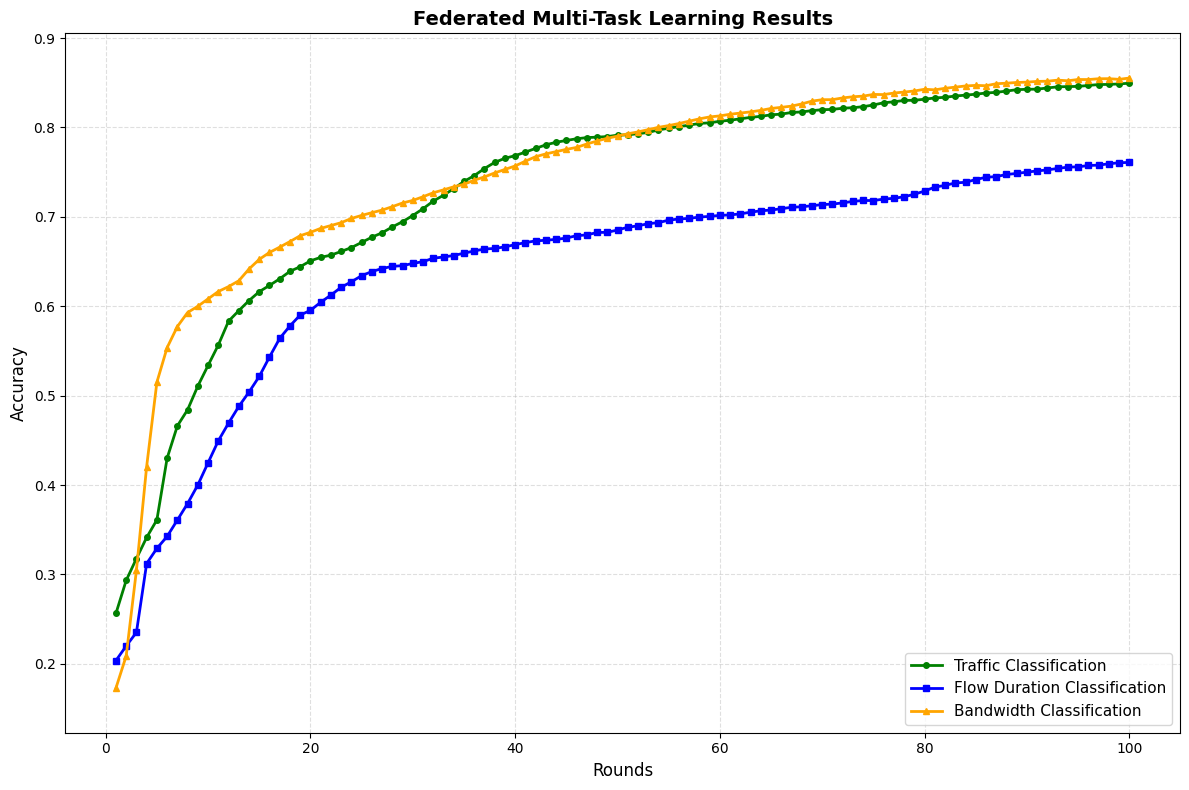

TRAINING SUMMARY
Total Rounds: 100

Final Accuracies (after training):
  Traffic:     0.8494 (84.94%)
  Duration:    0.7609 (76.09%)
  Bandwidth:   0.8553 (85.53%)

Best Accuracies:
  Traffic:     0.8494 (84.94%) at Round 100
  Duration:    0.7609 (76.09%) at Round 100
  Bandwidth:   0.8553 (85.53%) at Round 100

Improvement (from first to last round):
  Traffic:     +0.5930
  Duration:    +0.5571
  Bandwidth:   +0.6822


In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Check if required metrics exist
required_metrics = ['traffic_accuracy', 'duration_accuracy', 'bandwidth_accuracy']
missing_metrics = [metric for metric in required_metrics if metric not in history.metrics_distributed]

if missing_metrics:
    print(f"⚠️ Missing metrics: {missing_metrics}")
else:
    # Extract rounds and accuracies directly from history (no manual zero prepends)
    rounds = [r for r, _ in history.metrics_distributed['traffic_accuracy']]
    traffic_acc = [float(v) for _, v in history.metrics_distributed['traffic_accuracy']]
    duration_acc = [float(v) for _, v in history.metrics_distributed['duration_accuracy']]
    bandwidth_acc = [float(v) for _, v in history.metrics_distributed['bandwidth_accuracy']]

    # Calculate y-axis bounds dynamically
    all_accuracies = traffic_acc + duration_acc + bandwidth_acc
    y_min = max(0.0, min(all_accuracies) - 0.05)
    y_max = min(1.0, max(all_accuracies) + 0.05)

    # Create plot
    plt.figure(figsize=(12, 8))
    plt.plot(rounds, traffic_acc, color='green', label='Traffic Classification', linewidth=2, marker='o', markersize=4)
    plt.plot(rounds, duration_acc, color='blue', label='Flow Duration Classification', linewidth=2, marker='s', markersize=4)
    plt.plot(rounds, bandwidth_acc, color='orange', label='Bandwidth Classification', linewidth=2, marker='^', markersize=4)

    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Federated Multi-Task Learning Results', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=CFG['alpha'], linestyle='--')
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=" * 80)
    print("TRAINING SUMMARY")
    print("=" * 80)
    print(f"Total Rounds: {len(rounds)}")
    print(f"\nFinal Accuracies (after training):")
    print(f"  Traffic:     {traffic_acc[-1]:.4f} ({traffic_acc[-1]*100:.2f}%)")
    print(f"  Duration:    {duration_acc[-1]:.4f} ({duration_acc[-1]*100:.2f}%)")
    print(f"  Bandwidth:   {bandwidth_acc[-1]:.4f} ({bandwidth_acc[-1]*100:.2f}%)")
    
    print(f"\nBest Accuracies:")
    print(f"  Traffic:     {max(traffic_acc):.4f} ({max(traffic_acc)*100:.2f}%) at Round {rounds[np.argmax(traffic_acc)]}")
    print(f"  Duration:    {max(duration_acc):.4f} ({max(duration_acc)*100:.2f}%) at Round {rounds[np.argmax(duration_acc)]}")
    print(f"  Bandwidth:   {max(bandwidth_acc):.4f} ({max(bandwidth_acc)*100:.2f}%) at Round {rounds[np.argmax(bandwidth_acc)]}")
    
    print(f"\nImprovement (from first to last round):")
    print(f"  Traffic:     +{traffic_acc[-1] - traffic_acc[0]:.4f}")
    print(f"  Duration:    +{duration_acc[-1] - duration_acc[0]:.4f}")
    print(f"  Bandwidth:   +{bandwidth_acc[-1] - bandwidth_acc[0]:.4f}")
    print("=" * 80)


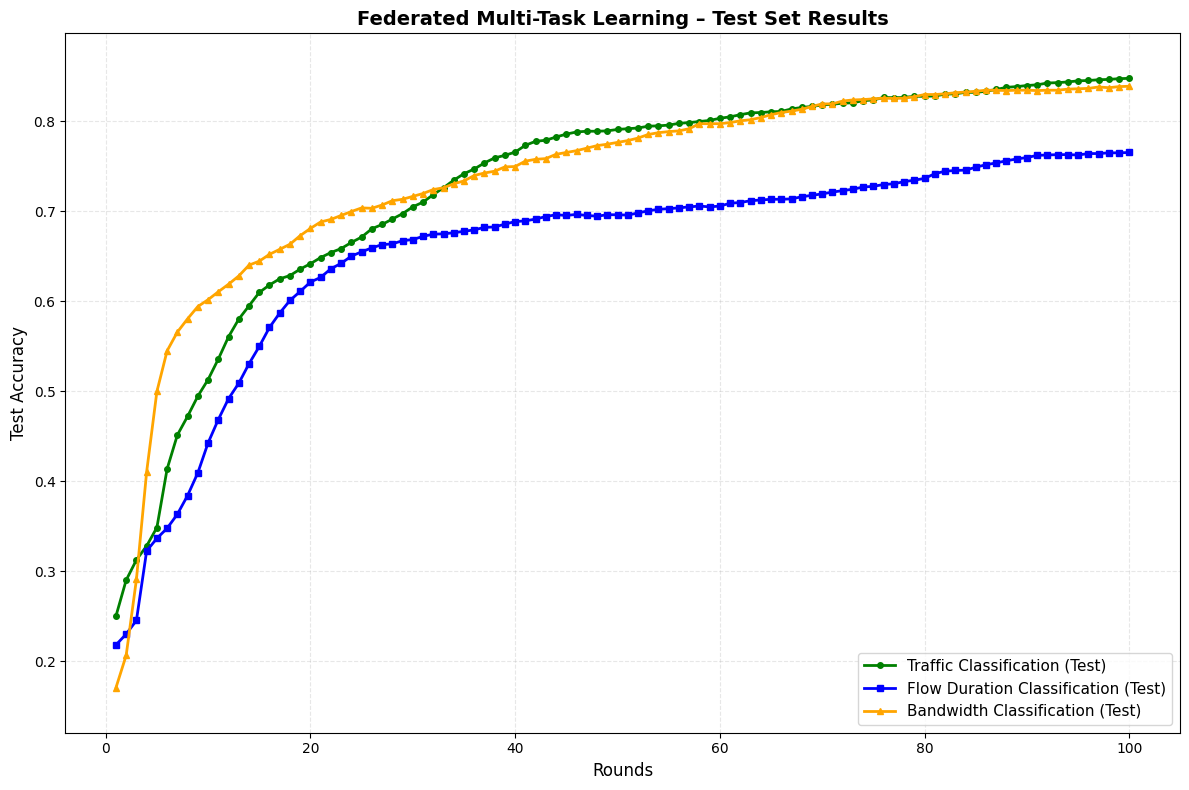

TEST SET EVALUATION SUMMARY
Total Rounds (with test evaluation): 100

Final Test Accuracies:
  Traffic:   0.8476 (84.76%)
  Duration:  0.7652 (76.52%)
  Bandwidth: 0.8388 (83.88%)

Best Test Accuracies:
  Traffic:   0.8476 (84.76%) at Round 100
  Duration:  0.7652 (76.52%) at Round 100
  Bandwidth: 0.8388 (83.88%) at Round 100

Improvement (from Round 1 to Round 100):
  Traffic:   +0.5976
  Duration:  +0.5472
  Bandwidth: +0.6684


In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Extract test accuracies from test_accuracies_by_round
if test_accuracies_by_round and len(test_accuracies_by_round) > 0:
    # Extract accuracies for each task
    test_traffic_acc = [item['traffic_accuracy'] for item in test_accuracies_by_round]
    test_duration_acc = [item['duration_accuracy'] for item in test_accuracies_by_round]
    test_bandwidth_acc = [item['bandwidth_accuracy'] for item in test_accuracies_by_round]

    # Use true round numbers from history (no manual zeros)
    test_rounds = [item['round'] for item in test_accuracies_by_round]

    # Calculate y-axis bounds dynamically
    all_test_accuracies = test_traffic_acc + test_duration_acc + test_bandwidth_acc
    y_min = max(0.0, min(all_test_accuracies) - 0.05)
    y_max = min(1.0, max(all_test_accuracies) + 0.05)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(test_rounds, test_traffic_acc, color='green', label='Traffic Classification (Test)', linewidth=2, marker='o', markersize=4)
    plt.plot(test_rounds, test_duration_acc, color='blue', label='Flow Duration Classification (Test)', linewidth=2, marker='s', markersize=4)
    plt.plot(test_rounds, test_bandwidth_acc, color='orange', label='Bandwidth Classification (Test)', linewidth=2, marker='^', markersize=4)

    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Federated Multi-Task Learning – Test Set Results', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

    # Summary stats
    print("=" * 80)
    print("TEST SET EVALUATION SUMMARY")
    print("=" * 80)
    print(f"Total Rounds (with test evaluation): {len(test_rounds)}")

    print(f"\nFinal Test Accuracies:")
    print(f"  Traffic:   {test_traffic_acc[-1]:.4f} ({test_traffic_acc[-1]*100:.2f}%)")
    print(f"  Duration:  {test_duration_acc[-1]:.4f} ({test_duration_acc[-1]*100:.2f}%)")
    print(f"  Bandwidth: {test_bandwidth_acc[-1]:.4f} ({test_bandwidth_acc[-1]*100:.2f}%)")

    print(f"\nBest Test Accuracies:")
    print(f"  Traffic:   {max(test_traffic_acc):.4f} ({max(test_traffic_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_traffic_acc)]}")
    print(f"  Duration:  {max(test_duration_acc):.4f} ({max(test_duration_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_duration_acc)]}")
    print(f"  Bandwidth: {max(test_bandwidth_acc):.4f} ({max(test_bandwidth_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_bandwidth_acc)]}")

    if len(test_traffic_acc) > 1:
        print(f"\nImprovement (from Round {test_rounds[0]} to Round {test_rounds[-1]}):")
        print(f"  Traffic:   +{test_traffic_acc[-1] - test_traffic_acc[0]:.4f}")
        print(f"  Duration:  +{test_duration_acc[-1] - test_duration_acc[0]:.4f}")
        print(f"  Bandwidth: +{test_bandwidth_acc[-1] - test_bandwidth_acc[0]:.4f}")
    print("=" * 80)

else:
    print("⚠️ No test accuracies found. Ensure test_data was passed to run_fedmtl_flower.")
    print(f"test_accuracies_by_round: {test_accuracies_by_round}")


In [ ]:
# 1. Check class distribution and majority baseline
from collections import Counter

def majority_acc(y):
    """Calculate majority class baseline accuracy"""
    c = Counter(y)
    if len(c) == 0:
        return 0.0
    most = c.most_common(1)[0][1]
    return most / len(y)

print("=" * 80)
print("CLASS DISTRIBUTION & MAJORITY BASELINE ANALYSIS")
print("=" * 80)

print("\n📊 Duration Classification:")
dur_series = pd.Series(y_dur_train)
print(dur_series.value_counts(normalize=True).sort_index())
dur_majority = majority_acc(y_dur_train)
print(f"Majority Baseline: {dur_majority:.4f} ({dur_majority*100:.2f}%)")

print("\n📊 Bandwidth Classification:")
bw_series = pd.Series(y_bw_train)
print(bw_series.value_counts(normalize=True).sort_index())
bw_majority = majority_acc(y_bw_train)
print(f"Majority Baseline: {bw_majority:.4f} ({bw_majority*100:.2f}%)")

print("\n📊 Traffic Classification:")
traf_series = pd.Series(y_traf_train)
traffic_counts = traf_series.value_counts(normalize=True).sort_index()
print(traffic_counts)
traf_majority = majority_acc(y_traf_train)
print(f"Majority Baseline: {traf_majority:.4f} ({traf_majority*100:.2f}%)")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print(f"If Round 0 accuracy is close to majority baseline, it's just class imbalance.")
print(f"Duration baseline: {dur_majority:.4f}, Bandwidth baseline: {bw_majority:.4f}")
print(f"Traffic baseline: {traf_majority:.4f}")

In [ ]:
def calculate_model_size_bytes(model):
    total_params = 0
    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            weights = layer.get_weights()
            for weight in weights:
                total_params += weight.size
    return total_params * 4  # Assuming float32 (4 bytes per parameter)

def compute_communication_cost_fedcpf(T, N, w_bytes):
    # Convert bytes to KB for comparison with paper
    w_kb = w_bytes / 1024
    
    # FedCPF formula: W = 2T(N * w)
    total_bytes = 2 * T * N * w_bytes
    total_kb = total_bytes / 1024
    total_mb = total_bytes / (1024 * 1024)
    total_gb = total_bytes / (1024 * 1024 * 1024)
    
    return {
        'total_bytes': total_bytes,
        'total_kb': total_kb,
        'total_mb': total_mb,
        'total_gb': total_gb,
        'model_size_bytes': w_bytes,
        'model_size_kb': w_kb,
        'rounds': T,
        'clients': N,
        'formula': f"W = 2 × {T} × {N} × {w_kb:.1f} KB"
    }

def analyze_communication_cost(history, model, cfg):

    # Calculate model size
    model_size_bytes = calculate_model_size_bytes(model)
    
    # Extract simulation parameters
    T = len(history.metrics_distributed.get('traffic_accuracy', []))  # Communication rounds
    N = cfg.get('n_clients_flat', 100)  # Number of clients
    w_bytes = model_size_bytes  # Model size in bytes
    
    # Calculate costs using FedCPF formula
    comm_cost = compute_communication_cost_fedcpf(T, N, w_bytes)
    
    # Additional metrics
    total_parameters = sum(w.size for w in model.get_weights())

    print()
    print(f"Formula: W = 2T(N × w)")
    print(f"Where:")
    print(f"  T (Rounds) = {T}")
    print(f"  N (Clients) = {N}")
    print(f"  w (Model Size) = {comm_cost['model_size_kb']:.1f} KB")
    print()
    print(f"Model Parameters: {total_parameters:,}")
    print(f"Model Size: {model_size_bytes:,} bytes ({comm_cost['model_size_kb']:.1f} KB)")
    print()
    print(f"  Formula: {comm_cost['formula']}")
    print(f"  Total Bytes: {comm_cost['total_bytes']:,}")
    print(f"  Total GB: {comm_cost['total_gb']:.4f}")
    print()
    
    
    return comm_cost

In [ ]:
comm_cost = analyze_communication_cost(history, final_model, CFG)

In [ ]:
print(history.metrics_distributed.keys())
print(history.metrics_distributed['traffic_accuracy'])

In [ ]:
# Define evaluate_model function
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_data):
    """
    Evaluate the multi-task model on test data
    
    Args:
        model: The trained FedMTLModel
        test_data: Dictionary with task names as keys and (X, y) tuples as values
        
    Returns:
        Dictionary with task names as keys and evaluation results as values
    """
    results = {}
    
    for task in ['traffic', 'duration', 'bandwidth']:
        if task not in test_data:
            continue
            
        X_test, y_test = test_data[task]
        X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
        
        # Get predictions
        logits = model(X_test_tensor, task=task, training=False)
        predictions = tf.argmax(logits, axis=1).numpy()
        
        # Calculate accuracy
        accuracy = np.mean(predictions == y_test)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, predictions)
        
        results[task] = {
            'accuracy': float(accuracy),
            'y_true': y_test,
            'predictions': predictions,
            'confusion_matrix': cm
        }
    
    return results

# ✅ CORRECT WAY TO CALL THE TEST FUNCTION

# 1. Make sure you have the trained model
print(f"Model type: {type(final_model)}")
print(f"Model built: {final_model.built}")

# 2. Verify test_data exists and has the right structure
print(f"\nTest data keys: {test_data.keys()}")
for task, (X, y) in test_data.items():
    print(f"  {task}: X shape={X.shape}, y shape={y.shape}, y type={type(y)}")

# 3. Run evaluation
print("\n" + "="*60)
print("Starting Test Evaluation...")
print("="*60)

test_results = evaluate_model(final_model, test_data)

# 4. Access individual results
print("\n📊 DETAILED RESULTS:")
for task, result in test_results.items():
    print(f"\n{task.upper()}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Number of samples: {len(result['y_true'])}")
    print(f"  Unique predictions: {np.unique(result['predictions'])}")
    print(f"  Confusion Matrix:\n{result['confusion_matrix']}")

# CH Compromise Study: Hierarchical Federated Learning

This section implements the CH compromise validation study using the same data from the single cluster test above.

- Both Equal and Dirichlet data splits
- Convergence (round 111) and Transient (round 11) compromise scenarios  
- 4-step recovery: Detection, Intra-Cluster Re-Election, Inter-Cluster Continuity, Re-Stabilization
- Context-aware gradual participation (30%, 70%, 100%)


## CH Compromise Study Configuration


In [74]:
# Configuration for CH Compromise Study (hierarchical setup)
CFG_CH = CFG.copy()  # Start with single cluster config
CFG_CH.update({
    'n_clusters': 3,  # Hierarchical: 3 clusters
    'clients_per_cluster': 200,  # 200 clients per cluster
    'client_frac': 1,
    
    # CH Compromise Study Parameters
    'rounds_total': 125,  # Total rounds
    'convergence_round': 90,  # When model converges
    'compromise_convergence': 111,  # Compromise at convergence
    'compromise_transient': 11,  # Compromise during transient
    'detection_rounds': 7,  # Detection & Re-Election phase duration
    'continuity_rounds': 3,  # Continuity phase duration
    'compromised_cluster': 0,  # Which cluster to compromise (CH 0)
    
    # Context-Aware Selection
    'alpha_energy': 0.6,  # Weight for energy in CH selection
    'beta_rssi': 0.4,  # Weight for RSSI in CH selection
})

print("✅ CH Compromise Study Configuration loaded")
print(f"   Total rounds: {CFG_CH['rounds_total']}")
print(f"   Clusters: {CFG_CH['n_clusters']}, Clients per cluster: {CFG_CH['clients_per_cluster']}")
print(f"   Compromise scenarios:")
print(f"     - Convergence: Round {CFG_CH['compromise_convergence']}")
print(f"     - Transient: Round {CFG_CH['compromise_transient']}")


✅ CH Compromise Study Configuration loaded
   Total rounds: 125
   Clusters: 3, Clients per cluster: 200
   Compromise scenarios:
     - Convergence: Round 111
     - Transient: Round 11


## CH Compromise Study: Data Structures and Classes


In [75]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# Client data structure for hierarchical setup
@dataclass
class ClientDataHierarchical:
    """Holds client's data for all tasks with cluster assignment"""
    ds: Dict[str, Tuple[np.ndarray, np.ndarray]]  # task -> (X, y)
    cluster_id: int
    client_id: int

# UAV Metrics dataclass
@dataclass
class UAVMetrics:
    """Metrics for UAV/client used in CH selection"""
    client_id: int
    cluster_id: int
    energy_residual: float
    rssi_avg: float
    num_examples: int
    param_change: float

print("✅ Data structures defined")


✅ Data structures defined


## Client Partitioning for Hierarchical Setup


In [76]:
def build_client_partitions_hierarchical(split_type='equal', verbose=True):
    """
    Build client partitions with specified data distribution for hierarchical setup
    
    Args:
        split_type: 'equal' or 'dirichlet'
        verbose: Print statistics
        
    Returns:
        clients: List of ClientDataHierarchical objects
        client_index_to_cluster: Dict mapping client idx to cluster id
    """
    n_clients = CFG_CH['n_clients_flat']
    n_clusters = CFG_CH['n_clusters']
    clients_per_cluster = CFG_CH['clients_per_cluster']
    
    if split_type == 'equal':
        # Equal split: divide samples equally among clusters
        samples_per_cluster = len(y_traf_train) // n_clusters
        cluster_indices = []
        
        for cluster_id in range(n_clusters):
            start_idx = cluster_id * samples_per_cluster
            end_idx = start_idx + samples_per_cluster if cluster_id < n_clusters - 1 else len(y_traf_train)
            cluster_indices.append(np.arange(start_idx, end_idx))
        
        # Divide each cluster's data among its clients
        client_indices_flat = []
        client_index_to_cluster = {}
        
        for cluster_id, cluster_idxs in enumerate(cluster_indices):
            np.random.shuffle(cluster_idxs)
            samples_per_client = len(cluster_idxs) // clients_per_cluster
            
            for local_client_id in range(clients_per_cluster):
                start = local_client_id * samples_per_client
                end = start + samples_per_client if local_client_id < clients_per_cluster - 1 else len(cluster_idxs)
                client_idxs = cluster_idxs[start:end]
                client_indices_flat.append(client_idxs)
                
                global_client_id = cluster_id * clients_per_cluster + local_client_id
                client_index_to_cluster[global_client_id] = cluster_id
        
    elif split_type == 'dirichlet':
        # Dirichlet split: non-IID distribution
        alpha = CFG_CH['alpha']
        min_size = 50
        rng = np.random.default_rng(seed)
        
        labels = np.unique(y_traf_train)
        label_indices = {}
        train_indices = np.arange(len(y_traf_train))
        
        for lbl in labels:
            label_indices[lbl] = train_indices[y_traf_train == lbl]
        
        client_bins = [[] for _ in range(n_clients)]
        
        for lbl in labels:
            idxs = label_indices[lbl]
            rng.shuffle(idxs)
            proportions = rng.dirichlet([alpha] * n_clients)
            cuts = (np.cumsum(proportions) * len(idxs)).astype(int)
            parts = np.split(idxs, cuts[:-1])
            
            for i, part in enumerate(parts):
                client_bins[i].extend(part.tolist())
        
        # Ensure minimum size
        for i in range(n_clients):
            if len(client_bins[i]) < min_size:
                need = min_size - len(client_bins[i])
                extra = rng.choice(train_indices, size=need, replace=False)
                client_bins[i].extend(extra.tolist())
        
        client_indices_flat = []
        client_index_to_cluster = {}
        
        for i, bin_data in enumerate(client_bins):
            clean = np.array(sorted(set(bin_data)))
            client_indices_flat.append(clean)
            
            # Assign to clusters sequentially
            cluster_id = i // clients_per_cluster
            client_index_to_cluster[i] = cluster_id
    
    else:
        raise ValueError(f"Unknown split_type: {split_type}")
    
    # Create ClientDataHierarchical objects
    clients = []
    for client_id, indices in enumerate(client_indices_flat):
        cluster_id = client_index_to_cluster[client_id]
        
        client_ds = {
            'traffic': (X_traffic_train[indices].astype(np.float32), y_traf_train[indices]),
            'duration': (X_duration_train[indices].astype(np.float32), y_dur_train[indices]),
            'bandwidth': (X_bandwidth_train[indices].astype(np.float32), y_bw_train[indices])
        }
        
        clients.append(ClientDataHierarchical(ds=client_ds, cluster_id=cluster_id, client_id=client_id))
    
    if verbose:
        print(f"✅ Client partitioning complete ({split_type} split):")
        print(f"   Total clients: {len(clients)}")
        print(f"   Clusters: {n_clusters}")
        print(f"   Clients per cluster: {clients_per_cluster}")
        
        sizes = [sum(len(c.ds[t][1]) for t in ['traffic', 'duration', 'bandwidth']) // 3 for c in clients]
        print(f"   Sample sizes: min={min(sizes)}, max={max(sizes)}, avg={np.mean(sizes):.1f}")
        
        # Check cluster distribution
        for cluster_id in range(n_clusters):
            cluster_clients = [c for c in clients if c.cluster_id == cluster_id]
            cluster_samples = sum(len(c.ds['traffic'][1]) for c in cluster_clients)
            print(f"   Cluster {cluster_id}: {len(cluster_clients)} clients, {cluster_samples} samples")
    
    return clients, client_index_to_cluster

print("✅ Client partitioning function defined")


✅ Client partitioning function defined


In [77]:
# Cluster-Aware Client with Context Metrics
class ClusterAwareClient(fl.client.NumPyClient):
    def __init__(self, model, client_data, cfg, cluster_id, client_id):
        self.model = model
        self.client_data = client_data
        self.cfg = cfg
        self.cluster_id = cluster_id
        self.client_id = client_id
        
        # Simulated context metrics for CH selection
        np.random.seed(seed + client_id)  # Deterministic per client
        self.energy_residual = np.random.uniform(0.5, 1.0)
        self.rssi_avg = np.random.uniform(0.6, 1.0)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=cfg['lr'])
        
        self.loss_fns = {
            'traffic': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'bandwidth': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        }
        
        self.loss_weights = cfg['loss_weights']
    
    def get_parameters(self, config):
        return self.model.get_weights()
    
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        initial_params = [np.copy(p) for p in parameters]
        
        # Local training
        total_loss = 0.0
        num_tasks = 0
        
        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                epoch_loss = 0.0
                epoch_tasks = 0
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.client_data or len(self.client_data[task][0]) == 0:
                        continue
                    
                    X_task, y_task = self.client_data[task]
                    X_task = tf.convert_to_tensor(X_task, dtype=tf.float32)
                    y_task = tf.convert_to_tensor(y_task, dtype=tf.int32)
                    
                    logits = self.model(X_task, task=task, training=True)
                    task_loss = self.loss_fns[task](y_task, logits)
                    weighted_loss = task_loss * self.loss_weights[task]
                    
                    epoch_loss += weighted_loss
                    epoch_tasks += 1
                
                if epoch_tasks > 0:
                    epoch_loss = epoch_loss / float(epoch_tasks)
                    total_loss += float(epoch_loss.numpy())
                    num_tasks = epoch_tasks
            
            if epoch_tasks > 0:
                grads = tape.gradient(epoch_loss, self.model.trainable_weights)
                if grads is not None and any(g is not None for g in grads):
                    self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        
        # Compute parameter change
        final_params = self.model.get_weights()
        param_change = np.mean([np.mean(np.abs(p1 - p2)) for p1, p2 in zip(initial_params, final_params)])
        
        # Count total examples
        num_examples = sum(len(self.client_data[t][1]) for t in ['traffic', 'duration', 'bandwidth'] 
                         if t in self.client_data)
        
        avg_loss = total_loss / max(self.cfg['local_epochs'], 1)
        
        return self.model.get_weights(), num_examples, {
            "loss": float(avg_loss),
            "param_change": float(param_change),
            "cluster_id": self.cluster_id,
            "client_id": self.client_id,
            "energy_residual": float(self.energy_residual),
            "rssi_avg": float(self.rssi_avg)
        }
    
    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        total_acc = 0.0
        num_tasks = 0
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data or len(self.client_data[task][0]) == 0:
                continue
            
            X, y = self.client_data[task]
            X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            logits = self.model(X_tensor, task=task, training=False)
            preds = tf.argmax(logits, axis=1).numpy()
            acc = float(np.mean(preds == y))
            total_acc += acc
            num_tasks += 1
        
        num_examples = sum(len(self.client_data[t][1]) for t in ['traffic', 'duration', 'bandwidth'] 
                         if t in self.client_data)
        
        return 0.0, num_examples, {"accuracy": total_acc / max(num_tasks, 1)}

print("✅ ClusterAwareClient defined")


✅ ClusterAwareClient defined


In [78]:
# Robust Hierarchical FedAvg with CH Compromise Recovery
class RobustHierarchicalFedAvg(fl.server.strategy.FedAvg):
    """
    Hierarchical FedAvg with robustness provisioning for CH compromise
    
    Recovery Steps:
    1. Detection: Skip compromised cluster for detection_rounds
    2. Intra-Cluster Re-Election: Context-aware CH selection
    3. Inter-Cluster Continuity: Healthy clusters continue global aggregation
    4. Re-Stabilization: Gradual participation (30%, 70%, 100%)
    """
    def __init__(
        self,
        test_data=None,
        model_class=None,
        in_dims=None,
        n_classes=None,
        max_dim=None,
        compromise_round=None,
        compromised_cluster=None,
        client_list=None,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.test_data = test_data
        self.model_class = model_class
        self.in_dims = in_dims
        self.n_classes = n_classes
        self.max_dim = max_dim
        
        # CH compromise parameters
        self.compromise_round = compromise_round
        self.compromised_cluster = compromised_cluster
        self.client_list = client_list or []
        
        # Recovery state
        self.ch_compromised = False
        self.compromise_detected_round = None
        self.recovery_phase = None
        
        # Tracking
        self.cluster_params_by_round = []
        self.cluster_test_accuracies_by_round = []
        self.current_parameters = None
        self.recovery_log = []
        self.cluster_uav_metrics = {}
        self.cluster_heads = {}
        
    def _ndarrays_weighted_average(self, param_list):
        """Weighted average of parameter arrays"""
        if not param_list:
            return None
        total_weight = float(sum(w for _, w in param_list))
        if total_weight <= 0:
            total_weight = 1.0
        summed = [np.zeros_like(arr, dtype=arr.dtype) for arr in param_list[0][0]]
        for arrays, w in param_list:
            for i, arr in enumerate(arrays):
                summed[i] = summed[i] + (arr * (w / total_weight))
        return summed
    
    def _context_aware_ch_selection(self, uav_metrics_list):
        """Select new CH based on context-aware formula"""
        if not uav_metrics_list:
            return 0
        
        energies = np.array([m.energy_residual for m in uav_metrics_list])
        rssis = np.array([m.rssi_avg for m in uav_metrics_list])
        
        # Normalize to [0, 1]
        energy_norm = (energies - energies.min()) / (energies.max() - energies.min() + 1e-8)
        rssi_norm = (rssis - rssis.min()) / (rssis.max() - rssis.min() + 1e-8)
        
        # Compute scores
        alpha = CFG_CH['alpha_energy']
        beta = CFG_CH['beta_rssi']
        scores = alpha * energy_norm + beta * rssi_norm
        
        # Select UAV with highest score
        selected_idx = np.argmax(scores)
        return uav_metrics_list[selected_idx].client_id
    
    def _get_gradual_participation_fraction(self, rounds_since_detection):
        """Determine participation fraction based on recovery phase"""
        detection_rounds = CFG_CH['detection_rounds']
        
        if rounds_since_detection < detection_rounds:
            return 0.0
        elif rounds_since_detection == detection_rounds:
            return 0.3
        elif rounds_since_detection == detection_rounds + 1:
            return 0.7
        else:
            return 1.0
    
    def aggregate_fit(self, server_round, results, failures):
        """Hierarchical aggregation with CH compromise recovery"""
        if len(results) == 0:
            return None, {}
        
        # Step 1: Check for CH compromise
        if (self.compromise_round is not None and 
            server_round == self.compromise_round and 
            not self.ch_compromised):
            
            self.ch_compromised = True
            self.compromise_detected_round = server_round
            self.recovery_phase = 'detection'
            
            print(f"\n🔴 CH COMPROMISE DETECTED: Round {server_round}, Cluster {self.compromised_cluster}")
            self.recovery_log.append({
                'round': server_round,
                'event': 'CH_COMPROMISE_DETECTED',
                'cluster': self.compromised_cluster
            })
        
        # Step 2: Extract client results with cluster information
        triples = []
        for client_proxy, fit_res in results:
            nds = fl.common.parameters_to_ndarrays(fit_res.parameters)
            weight = getattr(fit_res, 'num_examples', None)
            if weight is None:
                weight = int(fit_res.metrics.get('num_examples', 1)) if hasattr(fit_res, 'metrics') else 1
            cluster_id = int(fit_res.metrics.get('cluster_id', 0)) if hasattr(fit_res, 'metrics') else 0
            
            # Store UAV metrics for CH selection
            client_id = int(fit_res.metrics.get('client_id', 0)) if hasattr(fit_res, 'metrics') else 0
            uav_metric = UAVMetrics(
                client_id=client_id,
                cluster_id=cluster_id,
                energy_residual=fit_res.metrics.get('energy_residual', 0.75),
                rssi_avg=fit_res.metrics.get('rssi_avg', 0.8),
                num_examples=weight,
                param_change=fit_res.metrics.get('param_change', 0.01)
            )
            
            if cluster_id not in self.cluster_uav_metrics:
                self.cluster_uav_metrics[cluster_id] = []
            self.cluster_uav_metrics[cluster_id].append(uav_metric)
            
            triples.append((nds, weight, cluster_id, fit_res.metrics))
        
        # Step 3: Handle compromised cluster based on recovery phase
        participating_clusters = set()
        
        if self.ch_compromised and self.compromised_cluster is not None:
            rounds_since_detection = server_round - self.compromise_detected_round
            participation_fraction = self._get_gradual_participation_fraction(rounds_since_detection)
            
            # Update recovery phase
            detection_rounds = CFG_CH['detection_rounds']
            if rounds_since_detection < detection_rounds:
                self.recovery_phase = 'detection'
            elif rounds_since_detection < detection_rounds + CFG_CH['continuity_rounds']:
                if self.recovery_phase != 'continuity':
                    self.recovery_phase = 'continuity'
                    # Context-aware CH re-election
                    if self.compromised_cluster in self.cluster_uav_metrics:
                        cluster_uavs = self.cluster_uav_metrics[self.compromised_cluster]
                        new_ch = self._context_aware_ch_selection(cluster_uavs)
                        old_ch = self.cluster_heads.get(self.compromised_cluster, None)
                        self.cluster_heads[self.compromised_cluster] = new_ch
                        
                        print(f"\n✅ CH RE-ELECTION: Cluster {self.compromised_cluster}, New CH: {new_ch}")
                        self.recovery_log.append({
                            'round': server_round,
                            'event': 'CH_REELECTION',
                            'cluster': self.compromised_cluster,
                            'old_ch': old_ch,
                            'new_ch': new_ch
                        })
            else:
                if self.recovery_phase != 'complete':
                    self.recovery_phase = 'complete'
                    print(f"\n✅ RECOVERY COMPLETE: Round {server_round}")
                    self.recovery_log.append({
                        'round': server_round,
                        'event': 'RECOVERY_COMPLETE',
                        'cluster': self.compromised_cluster
                    })
        
        # Step 4: Intra-cluster aggregation
        cluster_to_pairs = {}
        
        for nds, w, cid, metrics in triples:
            # Handle compromised cluster
            if self.ch_compromised and cid == self.compromised_cluster:
                rounds_since_detection = server_round - self.compromise_detected_round
                participation_fraction = self._get_gradual_participation_fraction(rounds_since_detection)
                
                if participation_fraction == 0:
                    continue
                elif participation_fraction < 1.0:
                    client_id = int(metrics.get('client_id', 0))
                    cluster_to_pairs.setdefault(cid, []).append((nds, w, client_id, metrics))
                    continue
            
            cluster_to_pairs.setdefault(cid, []).append((nds, w, None, None))
        
        # Handle gradual participation for compromised cluster
        if self.ch_compromised and self.compromised_cluster in cluster_to_pairs:
            pairs_with_ids = cluster_to_pairs[self.compromised_cluster]
            rounds_since_detection = server_round - self.compromise_detected_round
            participation_fraction = self._get_gradual_participation_fraction(rounds_since_detection)
            
            if participation_fraction < 1.0:
                # Select top fraction by context score
                client_scores = []
                for nds, w, client_id, metrics in pairs_with_ids:
                    energy = metrics.get('energy_residual', 0.75)
                    rssi = metrics.get('rssi_avg', 0.8)
                    score = CFG_CH['alpha_energy'] * energy + CFG_CH['beta_rssi'] * rssi
                    client_scores.append((nds, w, score))
                
                # Sort by score and select top fraction
                client_scores.sort(key=lambda x: x[2], reverse=True)
                n_select = max(1, int(len(client_scores) * participation_fraction))
                selected = client_scores[:n_select]
                
                # Update cluster pairs
                cluster_to_pairs[self.compromised_cluster] = [(nds, w, None, None) for nds, w, _ in selected]
        
        # Aggregate within clusters
        cluster_params = {}
        cluster_weights = {}
        
        for cid, pairs in cluster_to_pairs.items():
            clean_pairs = [(nds, w) for nds, w, _, _ in pairs]
            if clean_pairs:
                cluster_params[cid] = self._ndarrays_weighted_average(clean_pairs)
                cluster_weights[cid] = float(sum(w for _, w in clean_pairs))
                participating_clusters.add(cid)
        
        if not cluster_params:
            print(f"⚠️  No clusters participating in round {server_round}")
            return self.current_parameters if self.current_parameters else None, {'accuracy': 0.0}
        
        # Step 5: Inter-cluster aggregation (global)
        global_pairs = [(arrs, cluster_weights[cid]) for cid, arrs in cluster_params.items()]
        averaged = self._ndarrays_weighted_average(global_pairs)
        aggregated_params = fl.common.ndarrays_to_parameters(averaged)
        
        self.current_parameters = aggregated_params
        self.cluster_params_by_round.append({cid: params for cid, params in cluster_params.items()})
        
        # Step 6: Evaluate on test set per cluster
        if self.test_data is not None and server_round > 0:
            per_cluster = {}
            
            for cid, params in cluster_params.items():
                temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                temp_model.build_all(self.max_dim)
                temp_model.set_weights(params)
                task_metrics = {}
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.test_data:
                        continue
                    X_test, y_test = self.test_data[task]
                    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
                    logits = temp_model(X_test_tensor, task=task, training=False)
                    preds = tf.argmax(logits, axis=1).numpy()
                    acc = float(np.mean(preds == y_test))
                    task_metrics[f'{task}_accuracy'] = acc
                
                per_cluster[int(cid)] = task_metrics
            
            self.cluster_test_accuracies_by_round.append({
                'round': int(server_round),
                'clusters': per_cluster,
                'participating_clusters': list(participating_clusters),
                'recovery_phase': self.recovery_phase
            })
        
        # Aggregate metrics
        accs = [metrics.get('accuracy') for _, _, _, metrics in triples if metrics and 'accuracy' in metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        
        metrics_out = {
            'accuracy': avg_acc,
            'participating_clusters': len(participating_clusters),
            'recovery_phase': self.recovery_phase or 'normal'
        }
        
        return aggregated_params, metrics_out

print("✅ RobustHierarchicalFedAvg defined")


✅ RobustHierarchicalFedAvg defined


In [79]:
def run_ch_experiment(split_type, compromise_round, scenario_name):
    """
    Run CH compromise experiment with specified parameters
    
    Args:
        split_type: 'equal' or 'dirichlet'
        compromise_round: When to compromise the CH
        scenario_name: Name for logging
        
    Returns:
        Dictionary with results
    """

    max_dim = max(X_traffic_train.shape[1], X_duration_train.shape[1], X_bandwidth_train.shape[1])
    
    in_dims = {
        'traffic': max_dim,
        'duration': max_dim,
        'bandwidth': max_dim 
    }
    
    n_classes = {
        'traffic': len(np.unique(y_traf_train)),
        'duration': len(np.unique(y_dur_train)),
        'bandwidth': len(np.unique(y_bw_train))
    }

    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"Split: {split_type}, Compromise Round: {compromise_round}")
    print(f"{'='*80}\n")
    
    # Build clients with specified split
    clients, client_index_to_cluster = build_client_partitions_hierarchical(split_type=split_type, verbose=True)
    
    # Get the FedMTLModel class from the run_fedmtl_flower function scope
    # We'll define it here to match the structure
    class FedMTLModelHierarchical(keras.Model):
        def __init__(self, in_dims, n_classes, dropout=0.1):
            super().__init__()
            self.tasks = ['traffic', 'duration', 'bandwidth']
            
            self.shared_dense1 = keras.layers.Dense(256, activation='relu', name='shared_dense1')
            self.shared_drop1 = keras.layers.Dropout(dropout)
            self.shared_dense2 = keras.layers.Dense(128, activation='relu', name='shared_dense2')
            self.shared_drop2 = keras.layers.Dropout(dropout)
            
            self.task_dense = {
                'traffic': keras.layers.Dense(6, activation='relu', name='task_traffic_dense'),
                'duration': keras.layers.Dense(32, activation='relu', name='task_duration_dense'),
                'bandwidth': keras.layers.Dense(64, activation='relu', name='task_bandwidth_dense')
            }
            
            self.task_heads = {
                'traffic': keras.layers.Dense(n_classes['traffic'], name='traffic_output'),
                'duration': keras.layers.Dense(n_classes['duration'], name='duration_output'),
                'bandwidth': keras.layers.Dense(n_classes['bandwidth'], name='bandwidth_output')
            }
        
        def call(self, x, task, training=False):
            x = self.shared_dense1(x)
            x = self.shared_drop1(x, training=training)
            x = self.shared_dense2(x)
            x = self.shared_drop2(x, training=training)
            x = self.task_dense[task](x)
            return self.task_heads[task](x)
        
        def build_all(self, input_dim):
            tf.random.set_seed(seed)
            x = tf.random.normal((1, input_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.call(x, task=t, training=False)
            self.built = True
    
    # Client function for Flower
    def client_fn(context: fl.common.Context) -> fl.client.Client:
        tf.random.set_seed(seed)
        client_idx = hash(context.node_id) % len(clients)
        client_obj = clients[client_idx]
        
        model = FedMTLModelHierarchical(in_dims, n_classes, dropout=0.1)
        model.build_all(max_dim)
        
        numpy_client = ClusterAwareClient(
            model=model,
            client_data=client_obj.ds,
            cfg=CFG_CH,
            cluster_id=client_obj.cluster_id,
            client_id=client_obj.client_id
        )
        return numpy_client.to_client()
    
    # Create global model template
    global_model_template = FedMTLModelHierarchical(in_dims, n_classes, dropout=0.1)
    global_model_template.build_all(max_dim)
    
    # Aggregation function
    def aggregate_metrics(metrics):
        aggregated = {}
        for num_examples, client_metrics in metrics:
            for metric_name, metric_value in client_metrics.items():
                if metric_name not in aggregated:
                    aggregated[metric_name] = []
                aggregated[metric_name].append(metric_value)
        for metric_name in aggregated:
            aggregated[metric_name] = np.mean(aggregated[metric_name])
        return aggregated
    
    # Create robust strategy
    strategy = RobustHierarchicalFedAvg(
        test_data=test_data,
        model_class=FedMTLModelHierarchical,
        in_dims=in_dims,
        n_classes=n_classes,
        max_dim=max_dim,
        compromise_round=compromise_round,
        compromised_cluster=CFG_CH['compromised_cluster'],
        client_list=clients,
        fraction_fit=CFG_CH['client_frac'],
        fraction_evaluate=CFG_CH['client_frac'],
        min_fit_clients=10,
        min_available_clients=len(clients),
        min_evaluate_clients=10,
        initial_parameters=fl.common.ndarrays_to_parameters(global_model_template.get_weights()),
        fit_metrics_aggregation_fn=aggregate_metrics,
        evaluate_metrics_aggregation_fn=aggregate_metrics,
    )
    
    # Run simulation
    print(f"\n🚀 Starting federated learning for {CFG_CH['rounds_total']} rounds...")
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=len(clients),
        config=fl.server.ServerConfig(num_rounds=CFG_CH['rounds_total']),
        strategy=strategy,
    )
    
    # Print recovery log
    if strategy.recovery_log:
        print(f"\n{'='*80}")
        print("RECOVERY LOG")
        print(f"{'='*80}")
        for event in strategy.recovery_log:
            print(f"Round {event['round']:3d}: {event['event']:25s} - Cluster {event.get('cluster', 'N/A')}")
        print(f"{'='*80}\n")
    
    return {
        'scenario_name': scenario_name,
        'split_type': split_type,
        'compromise_round': compromise_round,
        'history': history,
        'strategy': strategy,
        'model': global_model_template,
        'clients': clients,
        'client_index_to_cluster': client_index_to_cluster
    }

print("✅ run_ch_experiment function defined")


✅ run_ch_experiment function defined


## Visualization Functions (Larger Graphs)


In [80]:
import matplotlib.pyplot as plt

def plot_convergence_comparison(results_dict, cluster_id=0):
    """
    Plot side-by-side comparison for convergence case with LARGER graphs
    Left: Equal Split, Right: Dirichlet Split
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Increased from (20, 6) to (24, 8)
    
    scenarios = [
        ('equal_convergence', 'Equal Split (each cluster has 2500/3 samples)', 0),
        ('dirichlet_convergence', 'Dirichlet Split (2500 samples distributed among clusters)', 1)
    ]
    
    for scenario_key, title, ax_idx in scenarios:
        ax = axes[ax_idx]
        result = results_dict[scenario_key]
        strategy = result['strategy']
        cluster_accs = strategy.cluster_test_accuracies_by_round
        
        if not cluster_accs:
            continue
        
        # Extract data for specified cluster
        rounds = []
        traffic_acc = []
        duration_acc = []
        bandwidth_acc = []
        
        for entry in cluster_accs:
            if cluster_id in entry['clusters']:
                rounds.append(entry['round'])
                traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
                duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
                bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))
        
        # Plot with larger markers and thicker lines
        ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
        ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
        ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)
        
        # Mark convergence round
        ax.axvline(x=CFG_CH['convergence_round'], color='gray', linestyle='--', alpha=0.5, linewidth=2, label=f'round {CFG_CH['convergence_round']}')
        
        # Mark D&R-E phase
        compromise_r = result['compromise_round']
        detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
        ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(111-117)')
        
        # Mark Continuity phase
        continuity_start = detection_end + 1
        continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
        ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(118-120)')
        
        ax.set_xlabel('Rounds', fontsize=14)
        ax.set_ylabel('Test Accuracy', fontsize=14)
        ax.set_title(f'{title}', fontsize=15, fontweight='bold')
        ax.legend(loc='best', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.2, 1.0)
        ax.tick_params(labelsize=12)
    
    plt.suptitle(f'Convergence Case when CH Compromised Occurs - Cluster {cluster_id}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'ch_compromise_convergence_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
    plt.show()

def plot_transient_comparison(results_dict, cluster_id=0):
    """
    Plot side-by-side comparison for transient case with LARGER graphs
    Left: Equal Split, Right: Dirichlet Split
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Increased from (20, 6) to (24, 8)
    
    scenarios = [
        ('equal_transient', 'Equal Split (each cluster has 2500/3 samples)', 0),
        ('dirichlet_transient', 'Dirichlet Split (2500 samples distributed among clusters)', 1)
    ]
    
    for scenario_key, title, ax_idx in scenarios:
        ax = axes[ax_idx]
        result = results_dict[scenario_key]
        strategy = result['strategy']
        cluster_accs = strategy.cluster_test_accuracies_by_round
        
        if not cluster_accs:
            continue
        
        # Extract data for specified cluster
        rounds = []
        traffic_acc = []
        duration_acc = []
        bandwidth_acc = []
        
        for entry in cluster_accs:
            if cluster_id in entry['clusters']:
                rounds.append(entry['round'])
                traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
                duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
                bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))
        
        # Plot with larger markers and thicker lines
        ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
        ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
        ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)
        
        # Mark D&R-E phase
        compromise_r = result['compromise_round']
        detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
        ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(11-17)')
        
        # Mark Continuity phase
        continuity_start = detection_end + 1
        continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
        ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(18-20)')
        
        ax.set_xlabel('Rounds', fontsize=14)
        ax.set_ylabel('Test Accuracy', fontsize=14)
        ax.set_title(f'{title}', fontsize=15, fontweight='bold')
        ax.legend(loc='best', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.1, 0.8)
        ax.tick_params(labelsize=12)
    
    plt.suptitle(f'Non-Convergence (Transient) when CH Compromised Occurs - Cluster {cluster_id}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'ch_compromise_transient_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
    plt.show()

print("✅ Visualization functions defined (with larger graphs)")


✅ Visualization functions defined (with larger graphs)


## Execute CH Compromise Experiments

Running all four combinations:
1. Equal Split + Convergence (compromise at round 111)
2. Equal Split + Transient (compromise at round 11)
3. Dirichlet Split + Convergence (compromise at round 111)
4. Dirichlet Split + Transient (compromise at round 11)


In [81]:
# Store results
experiment_results = {}

print("Starting CH Compromise Study - 4 Scenarios")
print("=" * 80)
print(f"Total rounds per scenario: {CFG_CH['rounds_total']}")
print(f"Convergence point: Round {CFG_CH['convergence_round']}")
print(f"Compromised cluster: {CFG_CH['compromised_cluster']}")
print("=" * 80)


Starting CH Compromise Study - 4 Scenarios
Total rounds per scenario: 125
Convergence point: Round 90
Compromised cluster: 0


In [82]:
# Scenario 1: Equal Split + Convergence
results_equal_convergence = run_ch_experiment(
    split_type='equal',
    compromise_round=CFG_CH['compromise_convergence'],
    scenario_name='Equal Split - Convergence'
)
experiment_results['equal_convergence'] = results_equal_convergence


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=125, no round_timeout



SCENARIO: Equal Split - Convergence
Split: equal, Compromise Round: 111

✅ Client partitioning complete (equal split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=16, max=150, avg=16.7
   Cluster 0: 200 clients, 3333 samples
   Cluster 1: 200 clients, 3333 samples
   Cluster 2: 200 clients, 3334 samples

🚀 Starting federated learning for 125 rounds...


2025-11-30 03:02:58,265	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 7861077607.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :    


🔴 CH COMPROMISE DETECTED: Round 111, Cluster 0


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out o


✅ CH RE-ELECTION: Cluster 0, New CH: 107


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures



✅ RECOVERY COMPLETE: Round 121


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out o


RECOVERY LOG
Round 111: CH_COMPROMISE_DETECTED    - Cluster 0
Round 118: CH_REELECTION             - Cluster 0
Round 121: RECOVERY_COMPLETE         - Cluster 0



python(30682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [83]:
# Scenario 2: Equal Split + Transient
results_equal_transient = run_ch_experiment(
    split_type='equal',
    compromise_round=CFG_CH['compromise_transient'],
    scenario_name='Equal Split - Transient'
)
experiment_results['equal_transient'] = results_equal_transient


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=125, no round_timeout



SCENARIO: Equal Split - Transient
Split: equal, Compromise Round: 11

✅ Client partitioning complete (equal split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=16, max=150, avg=16.7
   Cluster 0: 200 clients, 3333 samples
   Cluster 1: 200 clients, 3333 samples
   Cluster 2: 200 clients, 3334 samples

🚀 Starting federated learning for 125 rounds...


python(30683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-11-30 04:41:01,148	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'memory': 8677851136.0}
INFO :      Optimize your simulation with Flower VCE:


🔴 CH COMPROMISE DETECTED: Round 11, Cluster 0


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 6


✅ CH RE-ELECTION: Cluster 0, New CH: 28


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 6


✅ RECOVERY COMPLETE: Round 21


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN


RECOVERY LOG
Round  11: CH_COMPROMISE_DETECTED    - Cluster 0
Round  18: CH_REELECTION             - Cluster 0
Round  21: RECOVERY_COMPLETE         - Cluster 0



python(45895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [84]:
# Scenario 3: Dirichlet Split + Convergence
results_dirichlet_convergence = run_ch_experiment(
    split_type='dirichlet',
    compromise_round=CFG_CH['compromise_convergence'],
    scenario_name='Dirichlet Split - Convergence'
)
experiment_results['dirichlet_convergence'] = results_dirichlet_convergence



SCENARIO: Dirichlet Split - Convergence
Split: dirichlet, Compromise Round: 111

✅ Client partitioning complete (dirichlet split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=48, max=85, avg=50.1
   Cluster 0: 200 clients, 9997 samples
   Cluster 1: 200 clients, 10049 samples
   Cluster 2: 200 clients, 10018 samples


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=125, no round_timeout



🚀 Starting federated learning for 125 rounds...


python(45896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-11-30 06:22:22,490	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'memory': 8020713472.0, 'object_store_memory': 2147483648.0}
INFO :      Optimize your simulation with Flower VCE:


🔴 CH COMPROMISE DETECTED: Round 111, Cluster 0


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out o


✅ CH RE-ELECTION: Cluster 0, New CH: 107


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures



✅ RECOVERY COMPLETE: Round 121


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out o


RECOVERY LOG
Round 111: CH_COMPROMISE_DETECTED    - Cluster 0
Round 118: CH_REELECTION             - Cluster 0
Round 121: RECOVERY_COMPLETE         - Cluster 0



python(61035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [85]:
# Scenario 4: Dirichlet Split + Transient
results_dirichlet_transient = run_ch_experiment(
    split_type='dirichlet',
    compromise_round=CFG_CH['compromise_transient'],
    scenario_name='Dirichlet Split - Transient'
)
experiment_results['dirichlet_transient'] = results_dirichlet_transient

print("\n✅ All 4 scenarios completed!")



SCENARIO: Dirichlet Split - Transient
Split: dirichlet, Compromise Round: 11

✅ Client partitioning complete (dirichlet split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=48, max=85, avg=50.1
   Cluster 0: 200 clients, 9997 samples
   Cluster 1: 200 clients, 10049 samples
   Cluster 2: 200 clients, 10018 samples


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=125, no round_timeout



🚀 Starting federated learning for 125 rounds...


python(61036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-11-30 08:07:41,309	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8660878951.0}
INFO :      Optimize your simulation with Flower VCE:


🔴 CH COMPROMISE DETECTED: Round 11, Cluster 0


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 6


✅ CH RE-ELECTION: Cluster 0, New CH: 107


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures



✅ RECOVERY COMPLETE: Round 21


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 6


RECOVERY LOG
Round  11: CH_COMPROMISE_DETECTED    - Cluster 0
Round  18: CH_REELECTION             - Cluster 0
Round  21: RECOVERY_COMPLETE         - Cluster 0


✅ All 4 scenarios completed!


python(76631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Generate CH Compromise Visualization Plots (Larger Size)


Plotting Convergence Case - Cluster 0


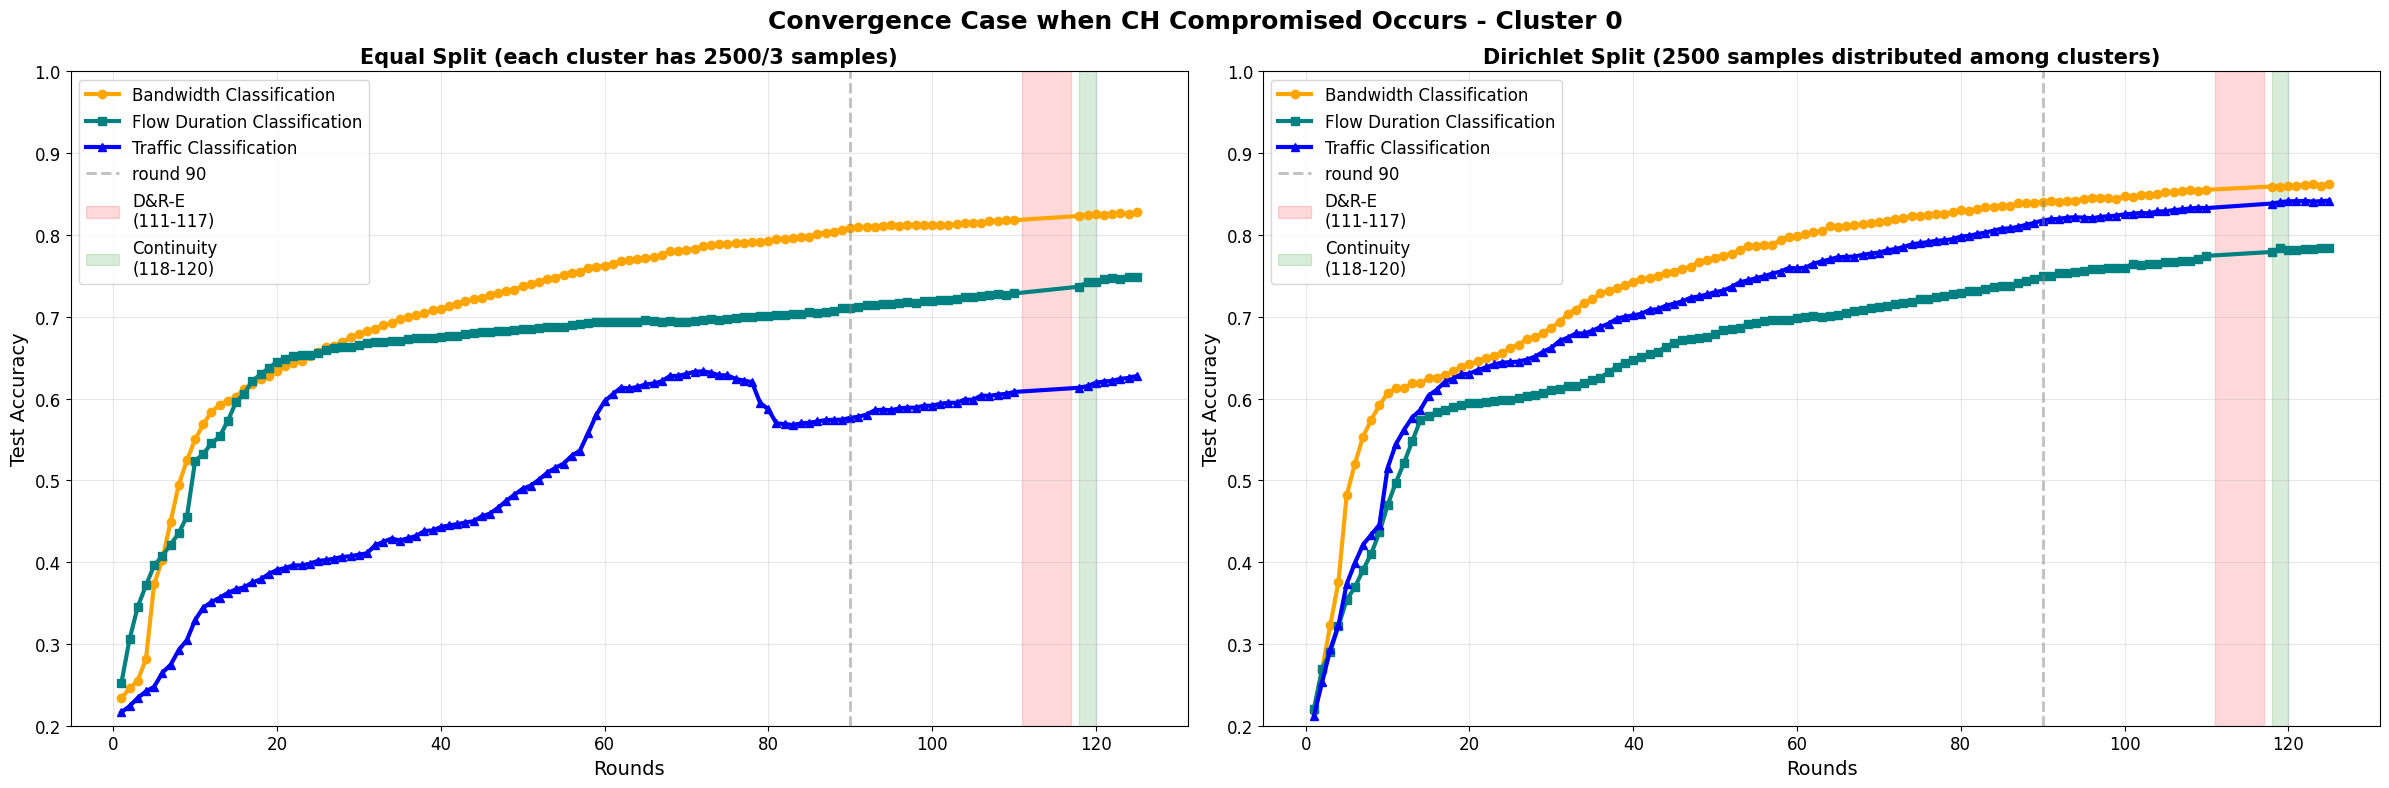

Plotting Convergence Case - Cluster 1


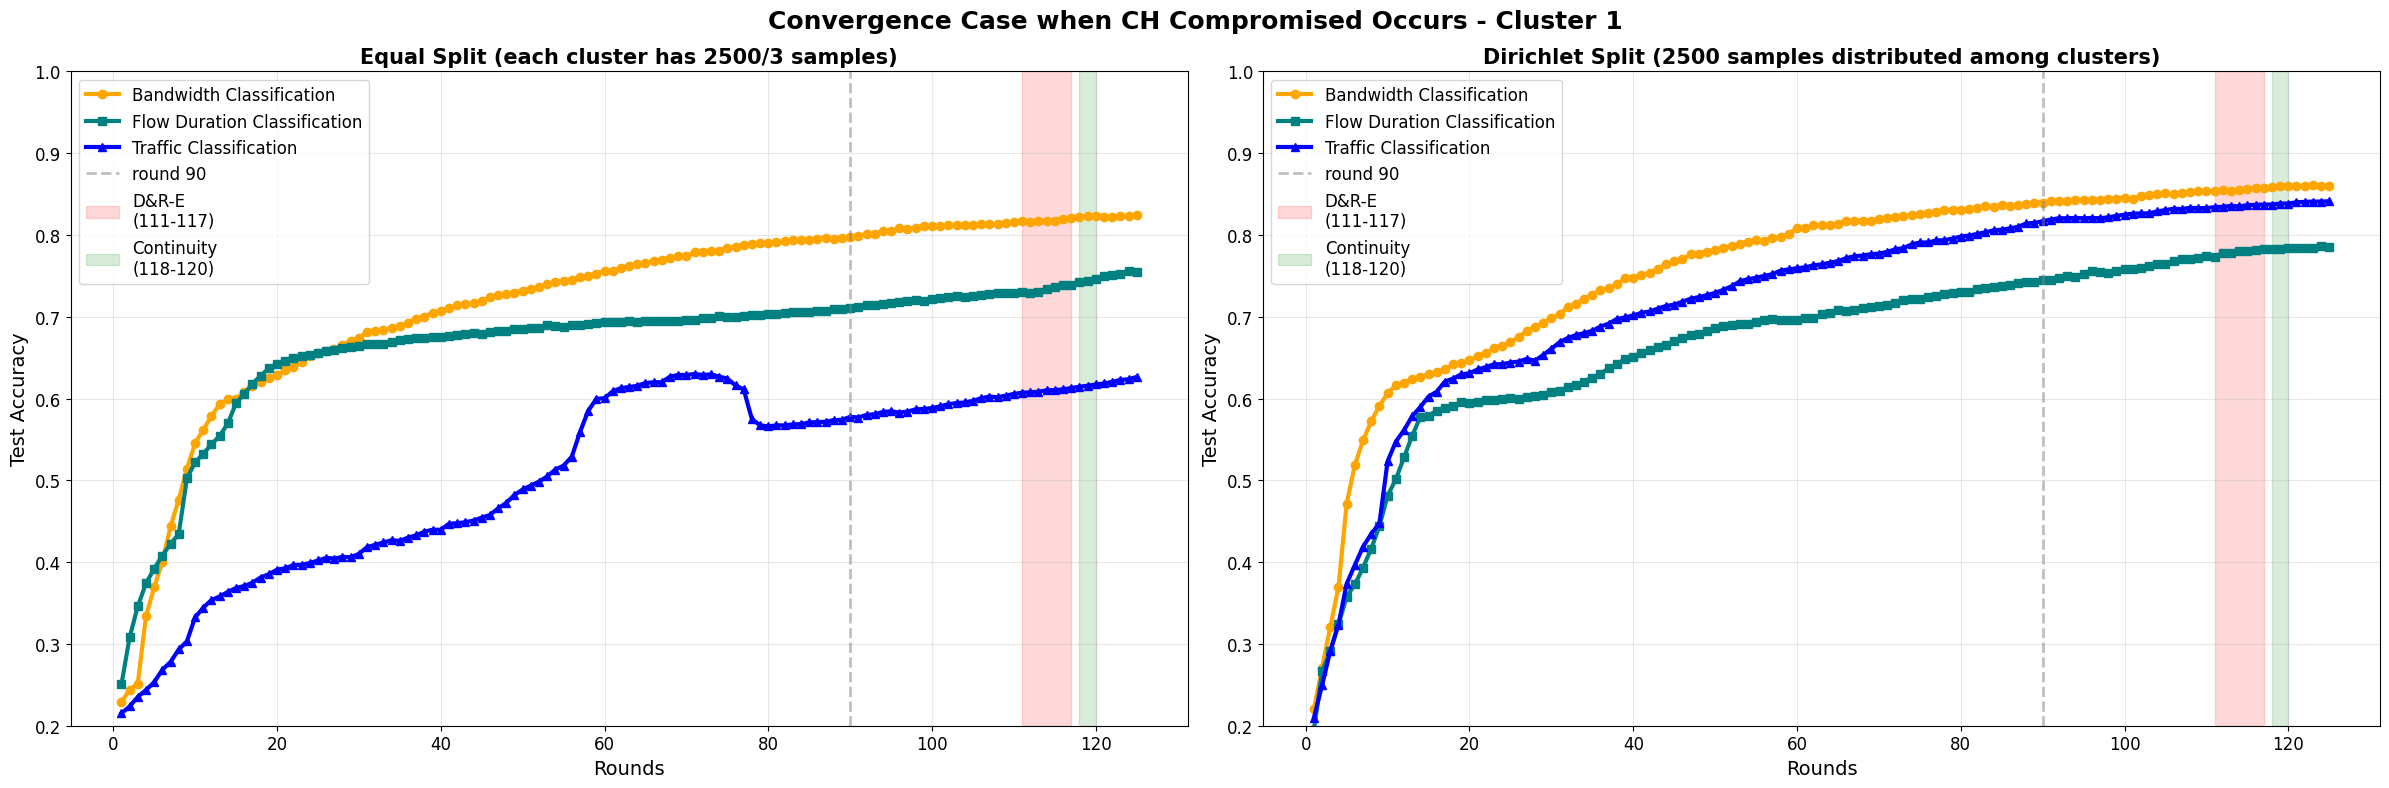

Plotting Convergence Case - Cluster 2


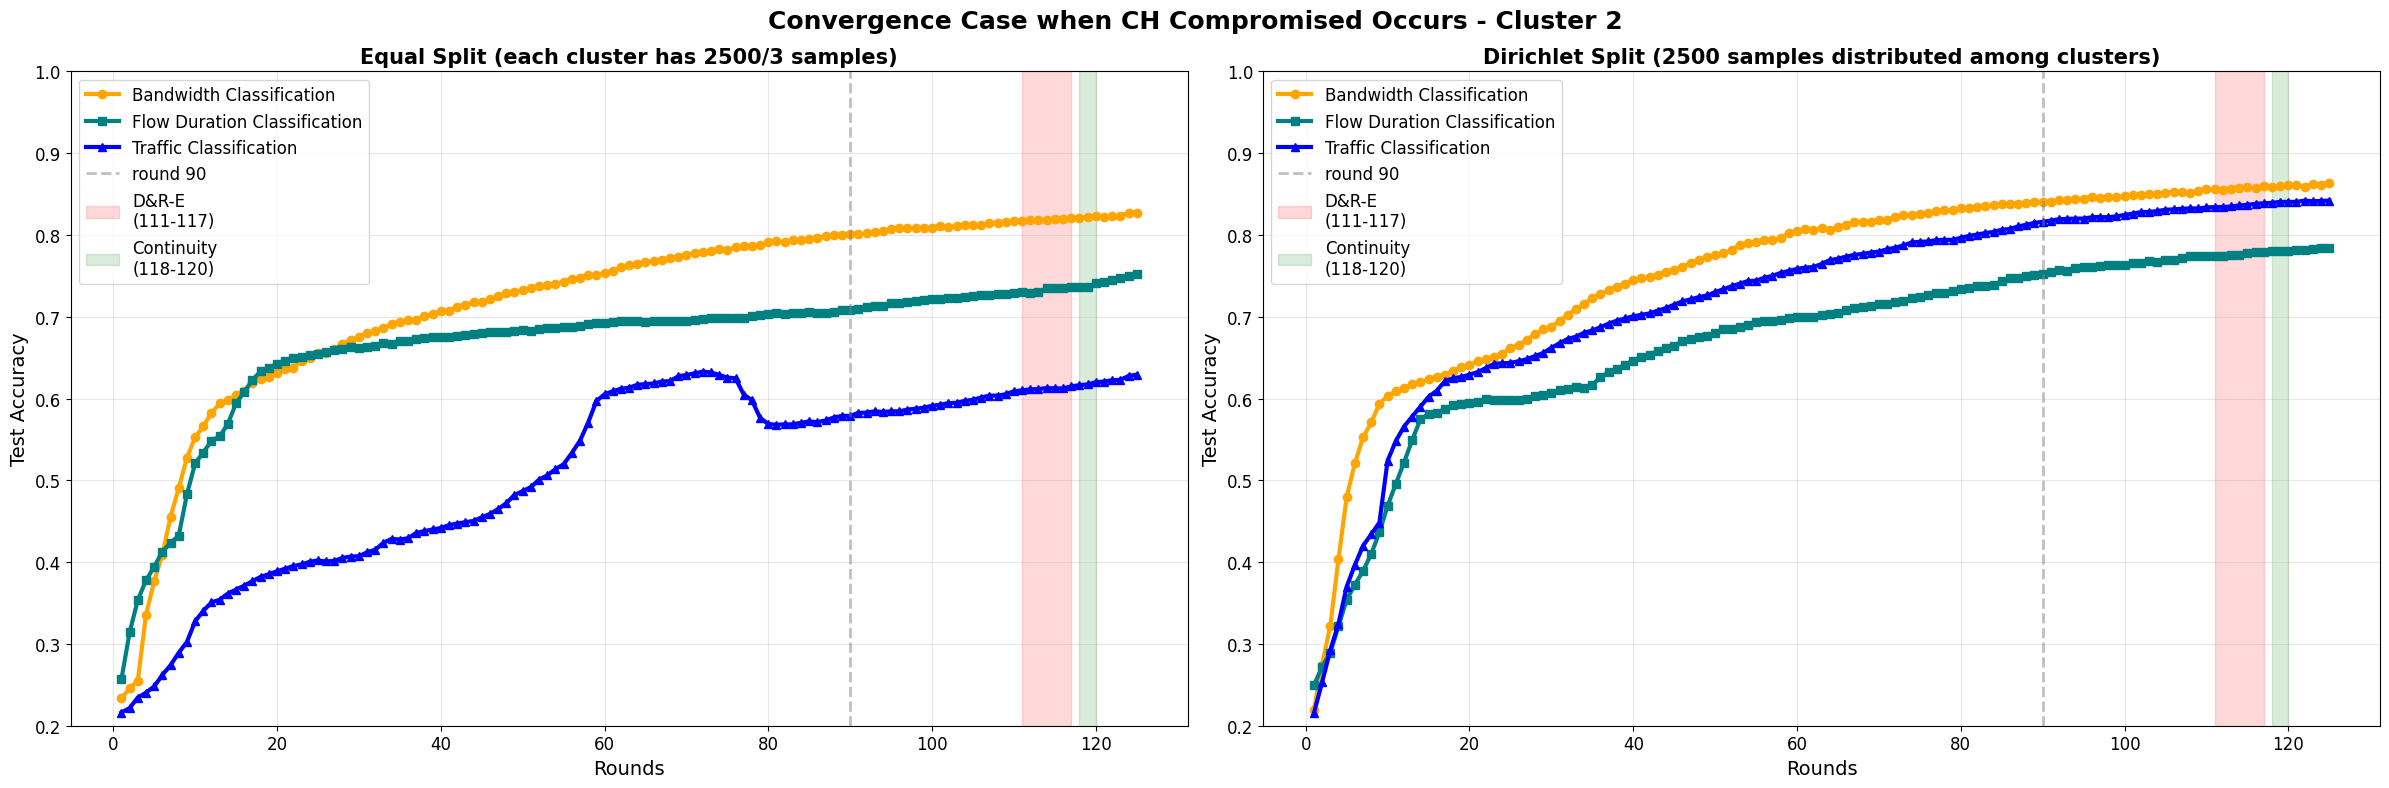

In [86]:
# Generate plots for all clusters - Convergence case
for cluster_id in range(CFG_CH['n_clusters']):
    print(f"Plotting Convergence Case - Cluster {cluster_id}")
    plot_convergence_comparison(experiment_results, cluster_id=cluster_id)



Plotting Transient Case - Cluster 0


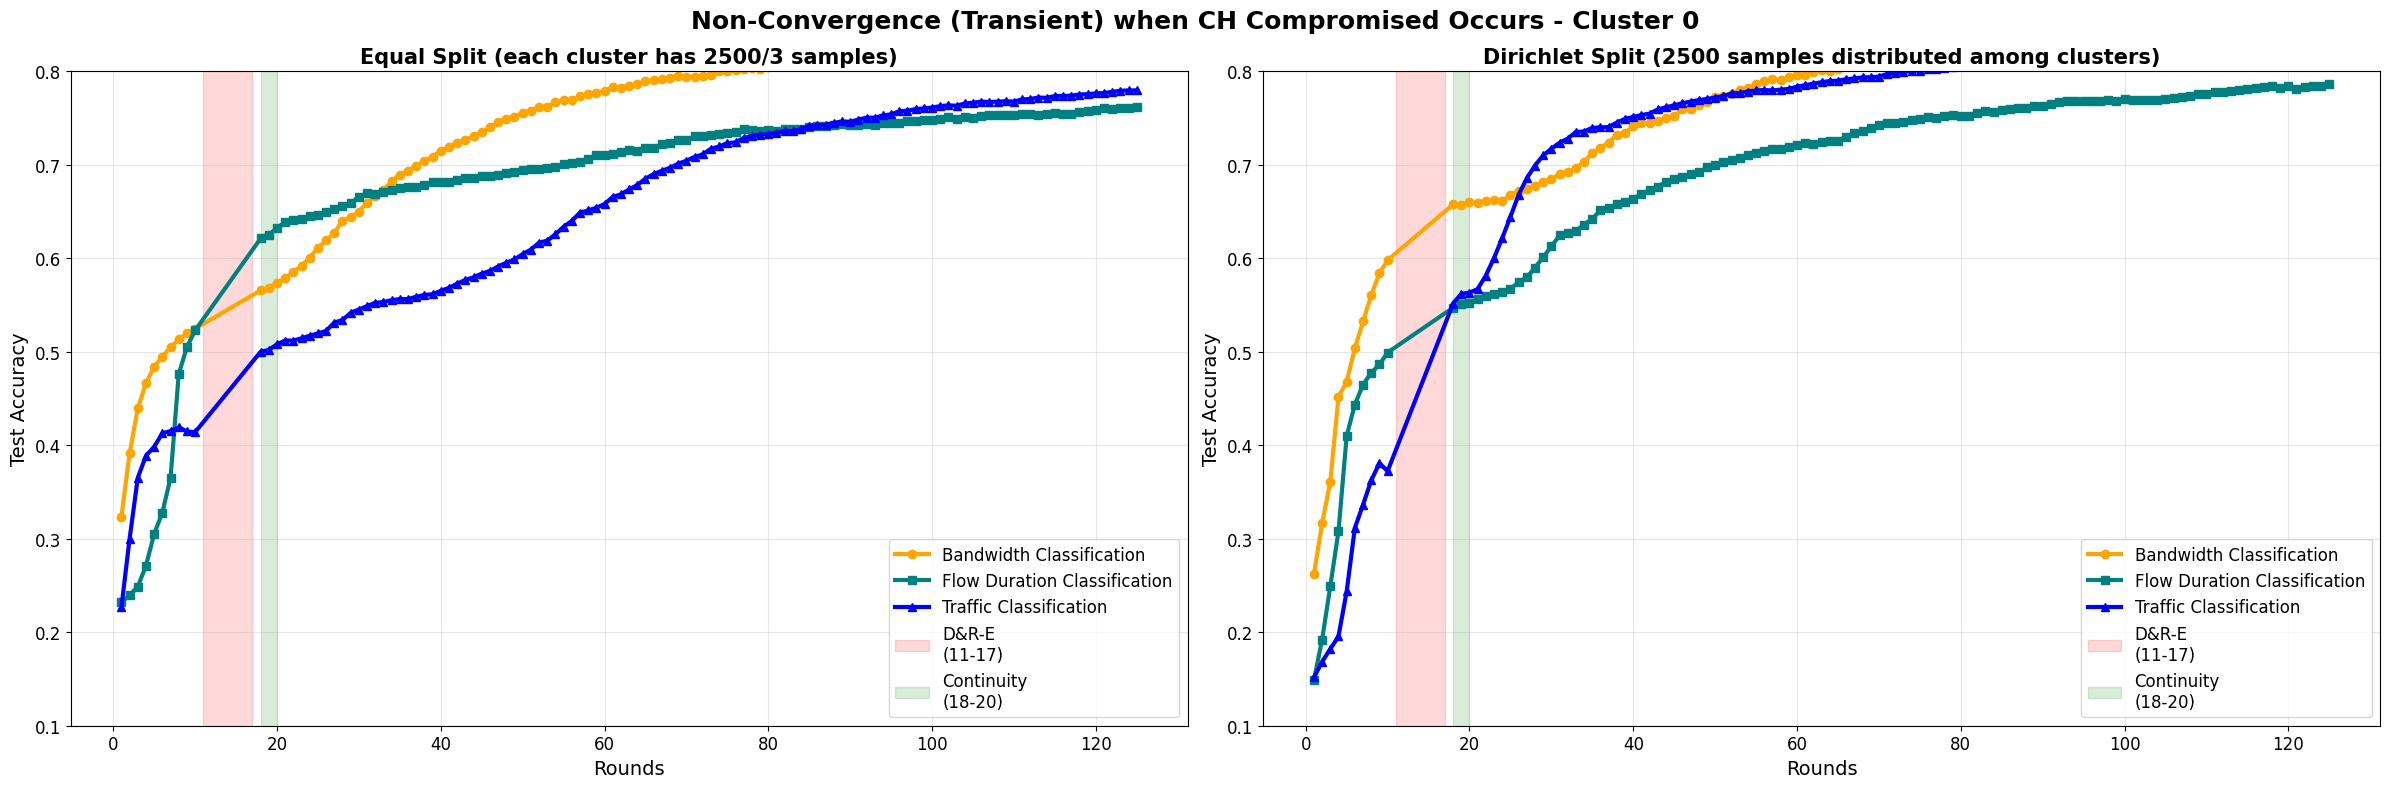


Plotting Transient Case - Cluster 1


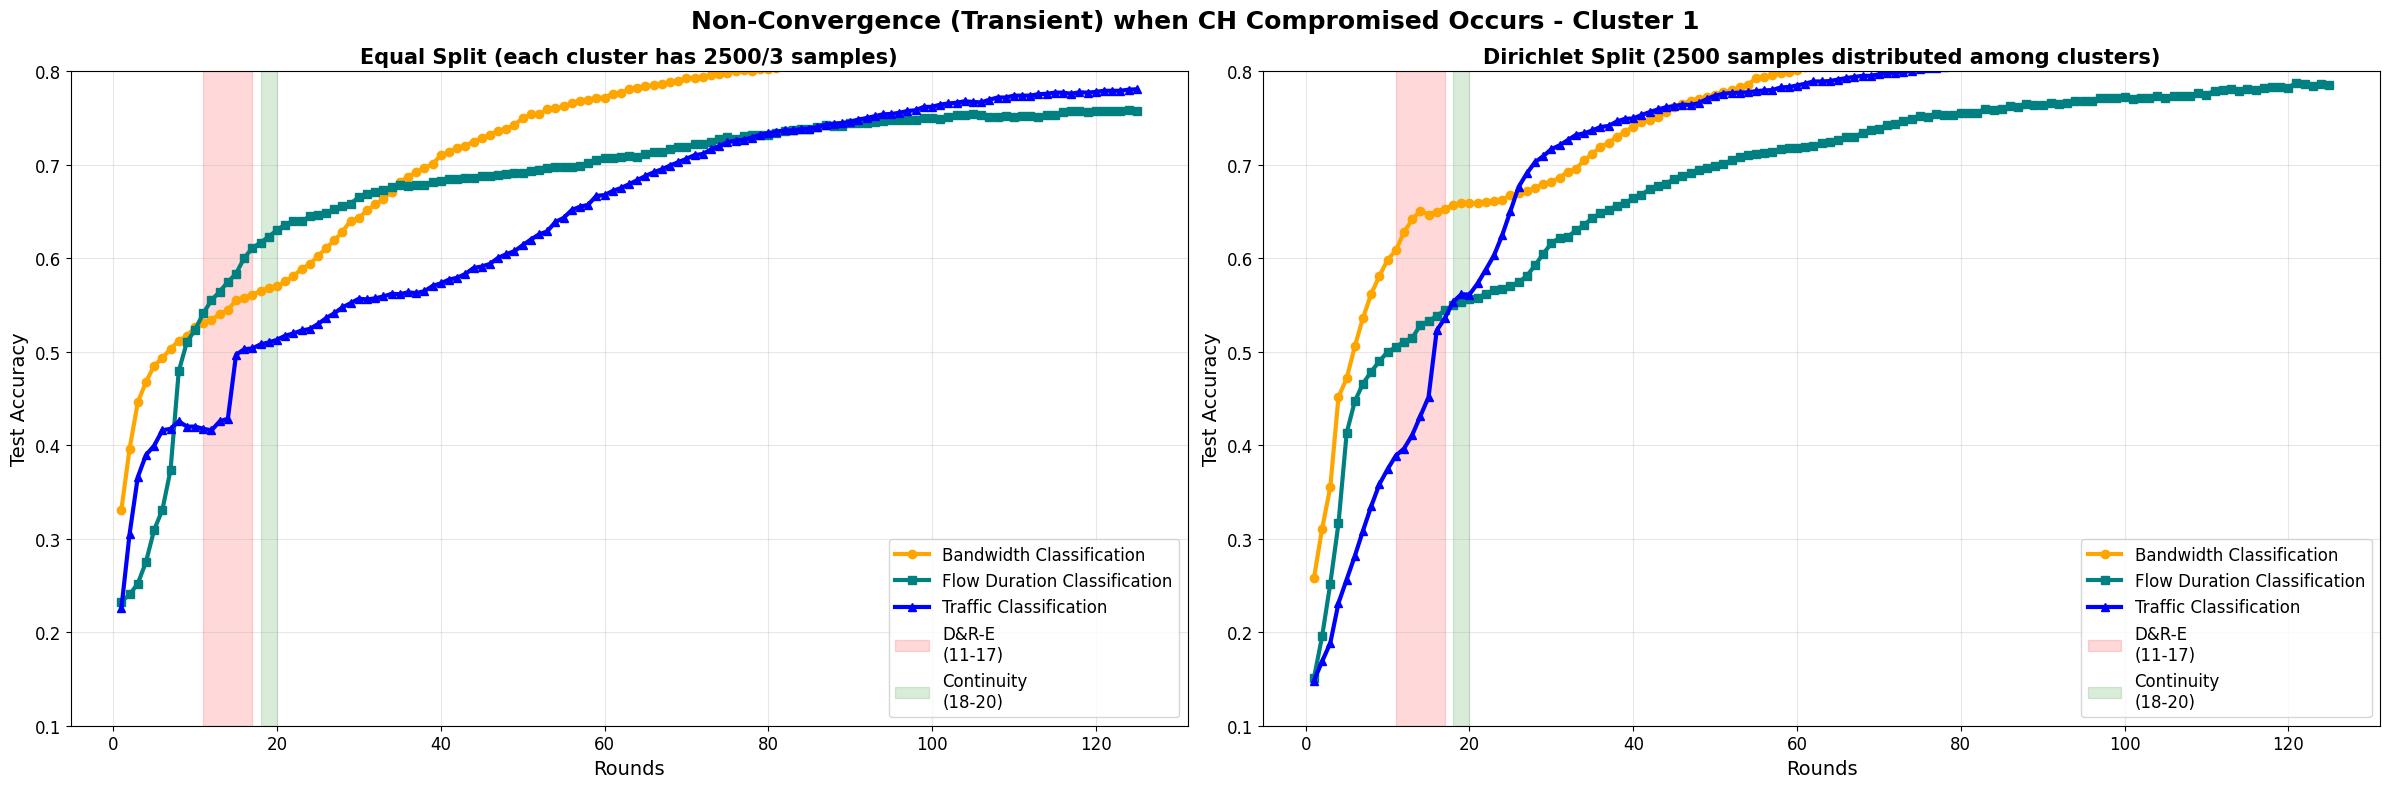


Plotting Transient Case - Cluster 2


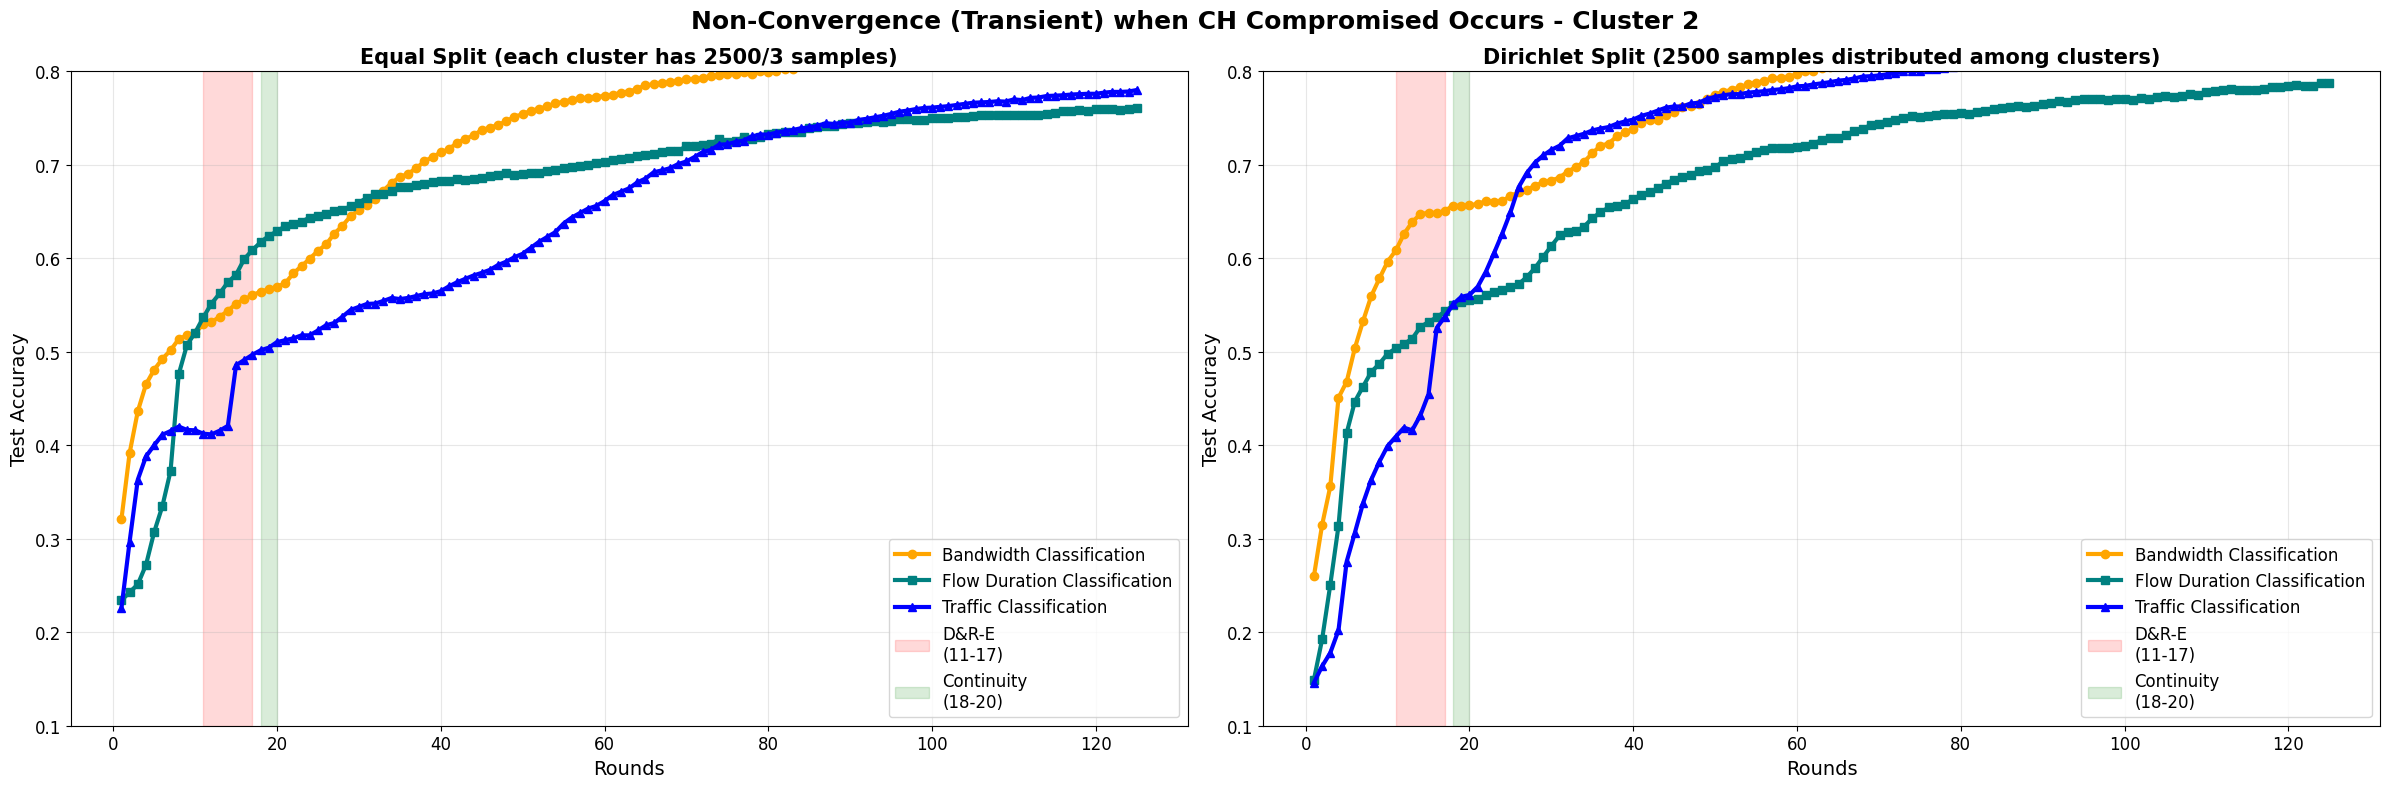

In [87]:
# Generate plots for all clusters - Transient case
for cluster_id in range(CFG_CH['n_clusters']):
    print(f"\n{'='*80}")
    print(f"Plotting Transient Case - Cluster {cluster_id}")
    print(f"{'='*80}")
    plot_transient_comparison(experiment_results, cluster_id=cluster_id)


In [ ]:
import matplotlib.pyplot as plt

# Equal Split Convergence - Cluster 0
cluster_id = 0
result = experiment_results['equal_convergence']
strategy = result['strategy']
cluster_accs = strategy.cluster_test_accuracies_by_round

# Extract data for cluster 0
rounds = []
traffic_acc = []
duration_acc = []
bandwidth_acc = []

for entry in cluster_accs:
    if cluster_id in entry['clusters']:
        rounds.append(entry['round'])
        traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
        duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
        bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)

# Mark convergence round
ax.axvline(x=CFG_CH['convergence_round'], color='gray', linestyle='--', alpha=0.5, linewidth=2, label=f'round {CFG_CH["convergence_round"]}')

# Mark D&R-E phase
compromise_r = result['compromise_round']
detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(111-117)')

# Mark Continuity phase
continuity_start = detection_end + 1
continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(118-120)')

ax.set_xlabel('Rounds', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Equal Split (each cluster has 2500/3 samples) - Convergence Case', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.2, 1.0)
ax.tick_params(labelsize=12)

plt.suptitle(f'CH Compromise - Convergence Case - Cluster {cluster_id}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'ch_compromise_equal_convergence_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Dirichlet Split Convergence - Cluster 0
cluster_id = 0
result = experiment_results['dirichlet_convergence']
strategy = result['strategy']
cluster_accs = strategy.cluster_test_accuracies_by_round

# Extract data for cluster 0
rounds = []
traffic_acc = []
duration_acc = []
bandwidth_acc = []

for entry in cluster_accs:
    if cluster_id in entry['clusters']:
        rounds.append(entry['round'])
        traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
        duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
        bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)

# Mark convergence round
ax.axvline(x=CFG_CH['convergence_round'], color='gray', linestyle='--', alpha=0.5, linewidth=2, label=f'round {CFG_CH["convergence_round"]}')

# Mark D&R-E phase
compromise_r = result['compromise_round']
detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(111-117)')

# Mark Continuity phase
continuity_start = detection_end + 1
continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(118-120)')

ax.set_xlabel('Rounds', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Dirichlet Split (2500 samples distributed among clusters) - Convergence Case', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.2, 1.0)
ax.tick_params(labelsize=12)

plt.suptitle(f'CH Compromise - Convergence Case - Cluster {cluster_id}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'ch_compromise_dirichlet_convergence_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Dirichlet Split Transient - Cluster 0
cluster_id = 0
result = experiment_results['dirichlet_transient']
strategy = result['strategy']
cluster_accs = strategy.cluster_test_accuracies_by_round

# Extract data for cluster 0
rounds = []
traffic_acc = []
duration_acc = []
bandwidth_acc = []

for entry in cluster_accs:
    if cluster_id in entry['clusters']:
        rounds.append(entry['round'])
        traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
        duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
        bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)

# Mark D&R-E phase
compromise_r = result['compromise_round']
detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(11-17)')

# Mark Continuity phase
continuity_start = detection_end + 1
continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(18-20)')

ax.set_xlabel('Rounds', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Dirichlet Split (2500 samples distributed among clusters) - Transient Case', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.0)  # Changed from (0.1, 0.8) to (0, 1.0)
ax.set_xlim(min(rounds), max(rounds))  # Set x-axis to show all rounds
ax.tick_params(labelsize=12)

plt.suptitle(f'CH Compromise - Non-Convergence (Transient) - Cluster {cluster_id}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'ch_compromise_dirichlet_transient_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Equal Split Transient - Cluster 0
cluster_id = 0
result = experiment_results['equal_transient']
strategy = result['strategy']
cluster_accs = strategy.cluster_test_accuracies_by_round

# Extract data for cluster 0
rounds = []
traffic_acc = []
duration_acc = []
bandwidth_acc = []

for entry in cluster_accs:
    if cluster_id in entry['clusters']:
        rounds.append(entry['round'])
        traffic_acc.append(entry['clusters'][cluster_id].get('traffic_accuracy', 0))
        duration_acc.append(entry['clusters'][cluster_id].get('duration_accuracy', 0))
        bandwidth_acc.append(entry['clusters'][cluster_id].get('bandwidth_accuracy', 0))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rounds, bandwidth_acc, 'o-', color='orange', label='Bandwidth Classification', linewidth=3, markersize=6)
ax.plot(rounds, duration_acc, 's-', color='teal', label='Flow Duration Classification', linewidth=3, markersize=6)
ax.plot(rounds, traffic_acc, '^-', color='blue', label='Traffic Classification', linewidth=3, markersize=6)

# Mark D&R-E phase
compromise_r = result['compromise_round']
detection_end = compromise_r + CFG_CH['detection_rounds'] - 1
ax.axvspan(compromise_r, detection_end, color='red', alpha=0.15, label='D&R-E\n(11-17)')

# Mark Continuity phase
continuity_start = detection_end + 1
continuity_end = continuity_start + CFG_CH['continuity_rounds'] - 1
ax.axvspan(continuity_start, continuity_end, color='green', alpha=0.15, label='Continuity\n(18-20)')

ax.set_xlabel('Rounds', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Equal Split (each cluster has 2500/3 samples) - Transient Case', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.0)  # Changed from (0.1, 0.8) to (0, 1.0)
ax.set_xlim(min(rounds), max(rounds))  # Set x-axis to show all rounds
ax.tick_params(labelsize=12)

plt.suptitle(f'CH Compromise - Non-Convergence (Transient) - Cluster {cluster_id}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'ch_compromise_equal_transient_cluster{cluster_id}.png', dpi=200, bbox_inches='tight')
plt.show()